In [14]:
!pip install numpy pandas pandas_datareader matplotlib seaborn yfinance scipy scikit-learn statsmodels

In [15]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

from scipy.stats import linregress
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
# Suppress the specific FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, message="The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.")

# Technical Features

In [16]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import yfinance as yf
from scipy.stats import kurtosis, skew

class SPYDataAnalyzer:
    def __init__(self, years=10, cache_file='spy_data.csv'):
        self.years = years
        self.cache_file = cache_file
        self.data = None
    
    def fetch_data(self):
        # Check if data is cached and is up-to-date
        if os.path.exists(self.cache_file):
            modified_time = datetime.fromtimestamp(os.path.getmtime(self.cache_file))
            if datetime.now() - modified_time < timedelta(days=1):
                self.data = pd.read_csv(self.cache_file, parse_dates=['Date'], index_col='Date')
                return

        # Fetch data from Yahoo Finance
        end_date = datetime.now()
        start_date = end_date - timedelta(days=self.years * 365)
        spy = yf.download('SPY', start=start_date, end=end_date)
        self.data = spy[['Open', 'High', 'Low', 'Close']]
        self.data.to_csv(self.cache_file)
    
    def calculate_indicators(self):
        if self.data is None:
            raise ValueError("No data available. Please fetch data first.")
        
        # Calculate moving averages
        self.data['20_MA'] = self.data['Close'].rolling(window=20).mean()
        self.data['52_Week_MA'] = self.data['Close'].rolling(window=260).mean()
        
        # Calculate Bollinger Bands for 20-day and 52-week
        self.data['20_Upper_BB'] = self.data['20_MA'] + 2 * self.data['Close'].rolling(window=20).std()
        self.data['20_Lower_BB'] = self.data['20_MA'] - 2 * self.data['Close'].rolling(window=20).std()
        self.data['52_Upper_BB'] = self.data['52_Week_MA'] + 2 * self.data['Close'].rolling(window=260).std()
        self.data['52_Lower_BB'] = self.data['52_Week_MA'] - 2 * self.data['Close'].rolling(window=260).std()
        
        # Calculate daily returns and other statistics
        self.data['Daily_Return'] = self.data['Close'].pct_change()
        self.data['Cumulative_Return'] = (1 + self.data['Daily_Return']).cumprod() - 1
        self.data['Std_Dev'] = self.data['Daily_Return'].rolling(window=20).std()
        
        # Calculate statistical metrics only where there are enough data points
        self.data['Skewness'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: skew(x.dropna()), raw=False)
        self.data['Kurtosis'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: kurtosis(x.dropna()), raw=False)
        self.data['Positive_Return_Percentage'] = self.data['Daily_Return'].rolling(window=20).apply(lambda x: (x > 0).mean() * 100, raw=False)
        
        # Calculate Kelly ratio and fraction based on available returns
        win_rate = self.data['Positive_Return_Percentage'] / 100
        loss_rate = 1 - win_rate
        avg_win = self.data[self.data['Daily_Return'] > 0]['Daily_Return'].mean()
        avg_loss = abs(self.data[self.data['Daily_Return'] <= 0]['Daily_Return'].mean())
        self.data['Kelly_Ratio'] = win_rate - (loss_rate / (avg_win / avg_loss))
        self.data['Kelly_Fraction'] = self.data['Kelly_Ratio'] / 2
        
        # Drop initial rows with NaN values after calculations
        self.data.dropna(inplace=True)

    def get_data(self):
        return self.data
    
    def save_to_csv(self, filename='spy_analyzed_data.csv'):
        if self.data is not None:
            self.data.to_csv(filename)
        else:
            raise ValueError("No data available to save. Please fetch and process data first.")

# Example usage
analyzer = SPYDataAnalyzer(years=10)
analyzer.fetch_data()
analyzer.calculate_indicators()
data = analyzer.get_data()
print(data.head())
# data.to_csv('spy_analyzed_output.csv')


                  Open        High         Low       Close       20_MA  \
Date                                                                     
2015-09-14  196.949997  197.009995  195.429993  196.009995  197.714001   
2015-09-15  196.610001  198.990005  195.960007  198.460007  197.107501   
2015-09-16  198.820007  200.410004  198.410004  200.179993  196.617501   
2015-09-17  200.020004  202.889999  199.279999  199.729996  196.188000   
2015-09-18  195.710007  198.679993  194.960007  195.449997  195.762000   

            52_Week_MA  20_Upper_BB  20_Lower_BB  52_Upper_BB  52_Lower_BB  \
Date                                                                         
2015-09-14  205.154193   210.258071   185.169930   217.385257   192.923128   
2015-09-15  205.146346   208.108348   186.106654   217.392008   192.900685   
2015-09-16  205.146231   205.950810   187.284192   217.392080   192.900382   
2015-09-17  205.140923   203.904356   188.471645   217.394991   192.886856   
2015-09-18  2

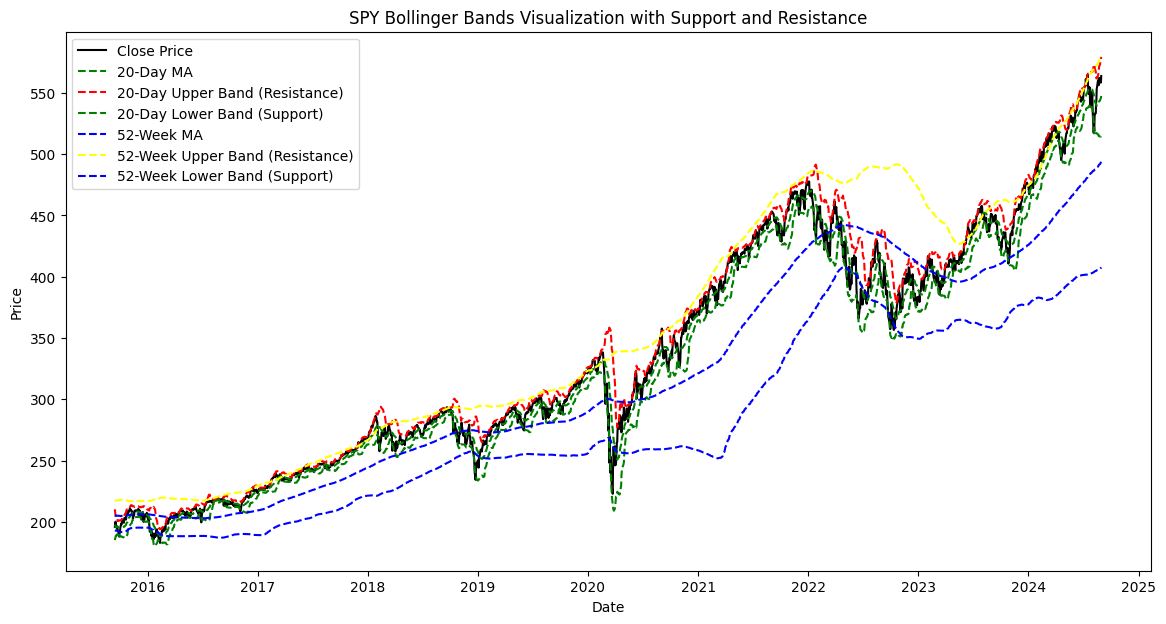

In [17]:
# Create a class to visualize the SPY data with Bollinger Bands
class SPYDataVisualizer:
    def __init__(self, data):
        self.data = data

    def clean_data(self):
        # Ensure all columns used for plotting are numeric
        self.data = self.data.apply(pd.to_numeric, errors='coerce')

        # Check and handle non-finite values (NaN, inf) directly
        self.data = self.data[np.isfinite(self.data['20_Upper_BB']) & np.isfinite(self.data['20_Lower_BB'])]
        self.data = self.data[np.isfinite(self.data['52_Upper_BB']) & np.isfinite(self.data['52_Lower_BB'])]

    def plot_bollinger_bands(self):
        self.clean_data()
        plt.figure(figsize=(14, 7))

        # Plotting the Close price
        plt.plot(self.data.index, self.data['Close'], label='Close Price', color='black')

        # Plotting 20-day moving average and Bollinger Bands
        plt.plot(self.data.index, self.data['20_MA'], label='20-Day MA', color='green', linestyle='--')
        plt.plot(self.data.index, self.data['20_Upper_BB'], color='red', linestyle='--', label='20-Day Upper Band (Resistance)')
        plt.plot(self.data.index, self.data['20_Lower_BB'], color='green', linestyle='--', label='20-Day Lower Band (Support)')

        # Plotting 52-week moving average and Bollinger Bands
        plt.plot(self.data.index, self.data['52_Week_MA'], label='52-Week MA', color='blue', linestyle='--')
        plt.plot(self.data.index, self.data['52_Upper_BB'], color='yellow', linestyle='--', label='52-Week Upper Band (Resistance)')
        plt.plot(self.data.index, self.data['52_Lower_BB'], color='blue', linestyle='--', label='52-Week Lower Band (Support)')

        plt.title('SPY Bollinger Bands Visualization with Support and Resistance')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.show()

# Load the data from the uploaded CSV file
data = pd.read_csv('./spy_analyzed_output.csv', parse_dates=['Date'], index_col='Date')

# Create an instance of the visualizer class and plot the data
visualizer = SPYDataVisualizer(data)
visualizer.plot_bollinger_bands()


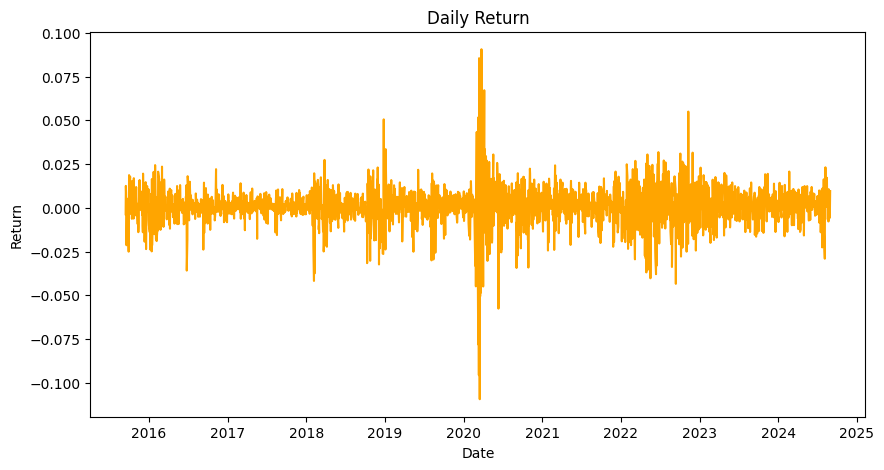

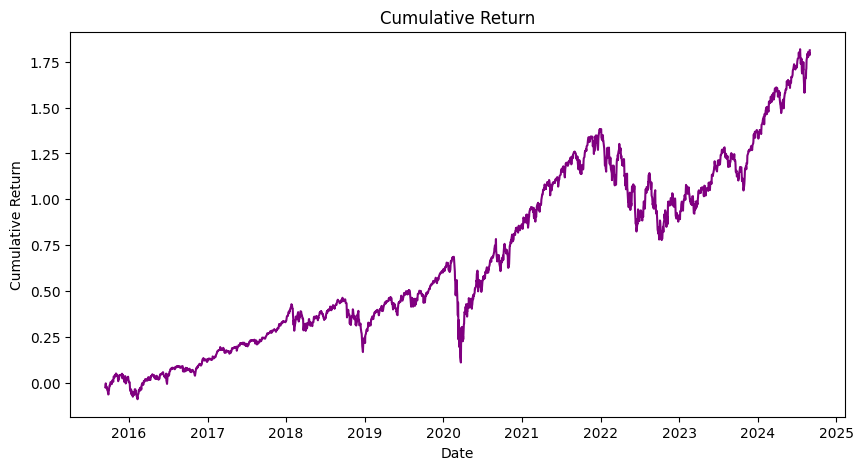

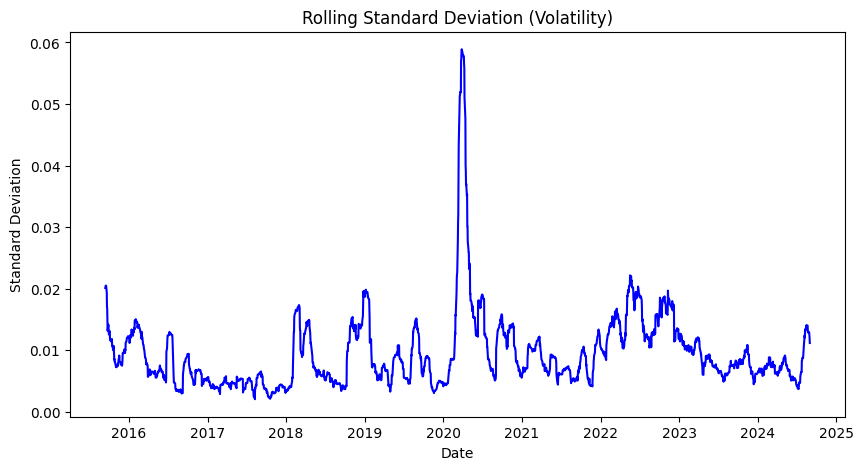

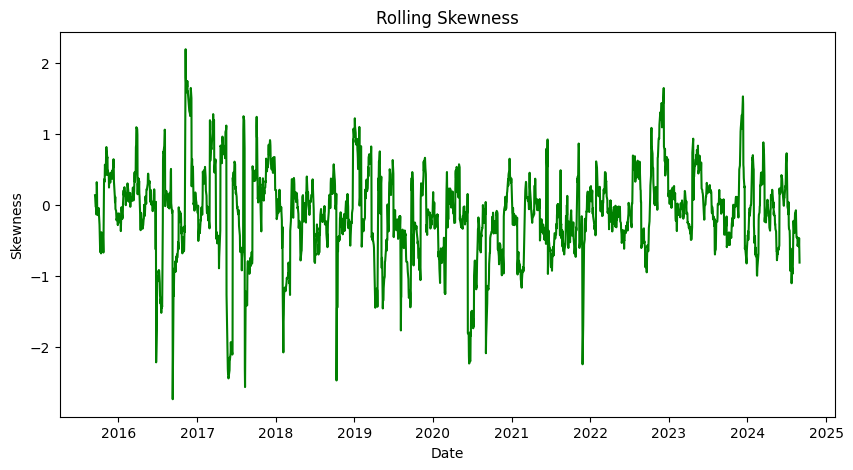

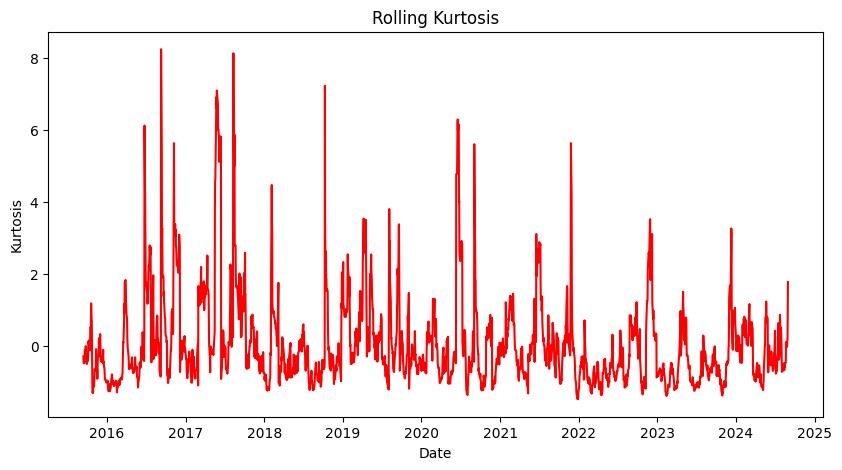

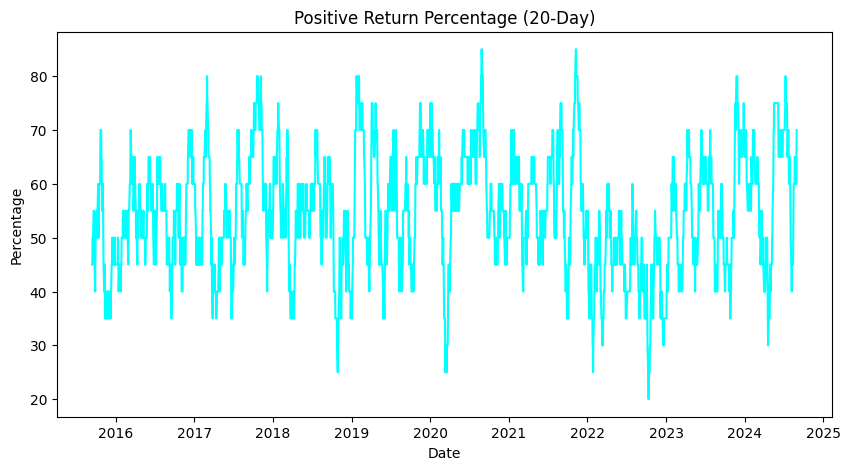

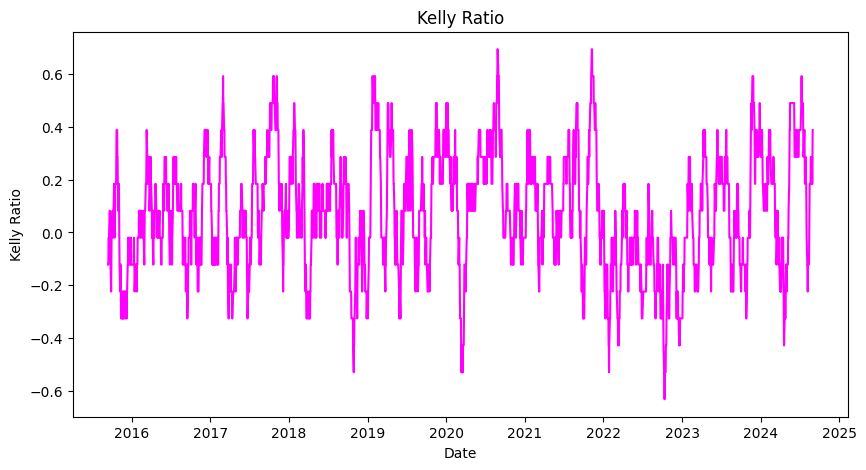

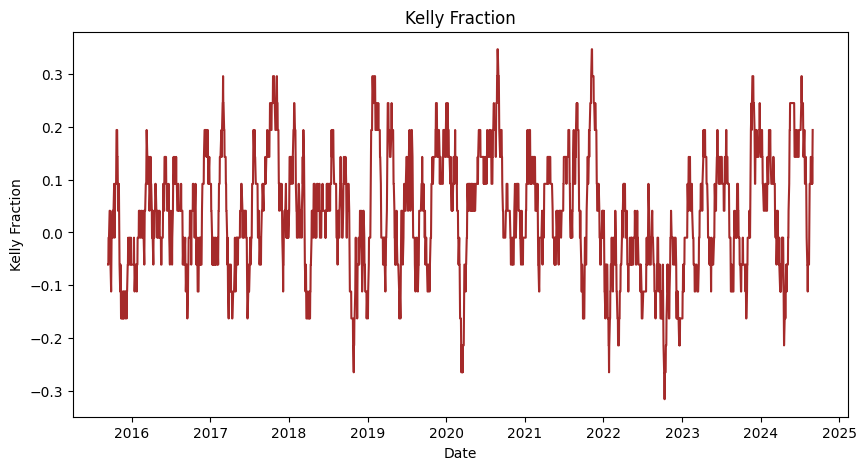

In [18]:
# Define separate classes for each type of visualization

# Class for Daily Return Visualization
class DailyReturnVisualizer:
    def __init__(self, data):
        self.data = data

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.data.index, self.data['Daily_Return'], color='orange')
        plt.title('Daily Return')
        plt.xlabel('Date')
        plt.ylabel('Return')
        plt.show()

# Class for Cumulative Return Visualization
class CumulativeReturnVisualizer:
    def __init__(self, data):
        self.data = data

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.data.index, self.data['Cumulative_Return'], color='purple')
        plt.title('Cumulative Return')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.show()

# Class for Standard Deviation (Volatility) Visualization
class VolatilityVisualizer:
    def __init__(self, data):
        self.data = data

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.data.index, self.data['Std_Dev'], color='blue')
        plt.title('Rolling Standard Deviation (Volatility)')
        plt.xlabel('Date')
        plt.ylabel('Standard Deviation')
        plt.show()

# Class for Skewness Visualization
class SkewnessVisualizer:
    def __init__(self, data):
        self.data = data

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.data.index, self.data['Skewness'], color='green')
        plt.title('Rolling Skewness')
        plt.xlabel('Date')
        plt.ylabel('Skewness')
        plt.show()

# Class for Kurtosis Visualization
class KurtosisVisualizer:
    def __init__(self, data):
        self.data = data

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.data.index, self.data['Kurtosis'], color='red')
        plt.title('Rolling Kurtosis')
        plt.xlabel('Date')
        plt.ylabel('Kurtosis')
        plt.show()

# Class for Positive Return Percentage Visualization
class PositiveReturnVisualizer:
    def __init__(self, data):
        self.data = data

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.data.index, self.data['Positive_Return_Percentage'], color='cyan')
        plt.title('Positive Return Percentage (20-Day)')
        plt.xlabel('Date')
        plt.ylabel('Percentage')
        plt.show()

# Class for Kelly Ratio Visualization
class KellyRatioVisualizer:
    def __init__(self, data):
        self.data = data

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.data.index, self.data['Kelly_Ratio'], color='magenta')
        plt.title('Kelly Ratio')
        plt.xlabel('Date')
        plt.ylabel('Kelly Ratio')
        plt.show()

# Class for Kelly Fraction Visualization
class KellyFractionVisualizer:
    def __init__(self, data):
        self.data = data

    def plot(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.data.index, self.data['Kelly_Fraction'], color='brown')
        plt.title('Kelly Fraction')
        plt.xlabel('Date')
        plt.ylabel('Kelly Fraction')
        plt.show()

# Load the data from the uploaded CSV file
data = pd.read_csv('./spy_analyzed_output.csv', parse_dates=['Date'], index_col='Date')

# Create instances of each visualizer class and plot separately
daily_return_viz = DailyReturnVisualizer(data)
cumulative_return_viz = CumulativeReturnVisualizer(data)
volatility_viz = VolatilityVisualizer(data)
skewness_viz = SkewnessVisualizer(data)
kurtosis_viz = KurtosisVisualizer(data)
positive_return_viz = PositiveReturnVisualizer(data)
kelly_ratio_viz = KellyRatioVisualizer(data)
kelly_fraction_viz = KellyFractionVisualizer(data)

# Visualize each separately
daily_return_viz.plot()
cumulative_return_viz.plot()
volatility_viz.plot()
skewness_viz.plot()
kurtosis_viz.plot()
positive_return_viz.plot()
kelly_ratio_viz.plot()
kelly_fraction_viz.plot()


# Thoughts
How would a quant interpret the data, to determine whether to buy share, or trade these options to hedge. For example, the Kelly fraction could be used to determine the % of a portfolio to DCA into individual shares or fractional shares. Low volatility and low probability of positive returns could mean a bearish call spread relative to % return, and high volatility and very low positive returns could be a bearish call ladder opportunity. I also could be entirely wrong about those examples, you tell me.

1. Kelly Fraction
Interpretation: The Kelly Fraction is a measure of how much of a portfolio should be allocated to an investment to maximize growth over the long term, balancing risk and reward. A higher Kelly Fraction suggests higher confidence in positive returns.
Usage:
High Kelly Fraction: Indicates favorable market conditions. This could signal that it’s a good time to buy shares or to enter a bull put spread as a way to generate income, expecting prices to stay above a certain level.
Low or Negative Kelly Fraction: Suggests caution, as the expected returns do not justify the risk. In such cases, a bear call spread might be appropriate to profit from expected declines or stagnation without risking too much capital.

2. Volatility (Standard Deviation)
Interpretation: High volatility means large price swings, which can offer more opportunities for options traders but also comes with higher risk. Low volatility suggests a stable market, which may favor more conservative strategies.
Usage:
High Volatility: Ideal for strategies that benefit from large price movements, like bear call ladders or bull put ladders. These strategies can profit from significant movement in either direction and are more suitable when large price swings are expected.
Low Volatility: Indicates stability, which might be better for strategies like bull put spreads where limited movement is expected. Here, you are betting that the price will not drop significantly below a certain level.

3. Positive Return Percentage
Interpretation: A high positive return percentage suggests that the stock has been frequently increasing in value, signaling bullish sentiment. A low percentage indicates bearish sentiment or market corrections.
Usage:
High Positive Return Percentage: A favorable outlook for buying shares or using a bull put spread. The expectation is that the price will remain stable or rise, allowing the puts sold at a higher strike to expire worthless, yielding profit.
Low Positive Return Percentage: May indicate a bearish outlook. Strategies like a bear call spread could be used to capitalize on the likelihood of the stock not surpassing a certain price level.

4. Skewness
Interpretation: Measures the asymmetry of return distribution. Positive skewness means more small losses and occasional large gains, while negative skewness implies more small gains with rare large losses.
Usage:
Positive Skewness: Suggests potential for occasional large gains. This could align with strategies like bull put ladders where you benefit from large upward movements while having limited downside risk.
Negative Skewness: Indicates frequent small gains but vulnerability to large drops. A bear call spread or bear call ladder might be suitable to protect against significant declines.

5. Kurtosis
Interpretation: High kurtosis indicates a lot of outliers—extreme returns, both positive and negative. Low kurtosis suggests returns are closer to a normal distribution.
Usage:
High Kurtosis: High risk of large moves. Strategies like ladders (bear call or bull put) are appropriate as they can capitalize on large price movements while capping potential losses.
Low Kurtosis: Less risk of extreme moves. More stable environments where simple spread strategies might be preferable, such as a bull put spread for a bullish outlook or a bear call spread for a bearish outlook.

Example Application:

Scenario 1: If the Kelly Fraction is high, volatility is low, and the positive return percentage is high, a quant might prefer dollar-cost averaging (DCA) into shares, as this indicates a strong, stable bullish trend. Alternatively, a bull put spread could be used to generate income while maintaining limited risk.

Scenario 2: If volatility is high, Kelly Fraction is low, and skewness is negative (suggesting risk of large downward moves), a bear call ladder might be used. This strategy could profit from large downward movements while limiting potential losses.

Scenario 3: If skewness and kurtosis are both high, indicating frequent small gains but risk of large losses, a bear call spread could be a good defensive strategy, protecting against sharp declines while allowing some profit if the price remains below a certain level.

In [19]:
# Analyze the existing data for monthly performance
import pandas as pd

# Load the data from the CSV file (assuming it has been uploaded previously)
data = pd.read_csv('./spy_analyzed_output.csv', parse_dates=['Date'], index_col='Date')

# Create a new column for the month to categorize data
data['Month'] = data.index.month

# Function to categorize months
def categorize_month(month):
    if month in [8, 9]:  # August, September
        return 'Bearish'
    elif month in [1, 4, 11, 12]:  # January, April, November, December
        return 'Bullish'
    else:
        return 'Neutral'

# Apply the categorization function
data['Month_Category'] = data['Month'].apply(categorize_month)

# Calculate average metrics for each month category
monthly_stats = data.groupby('Month_Category').agg({
    'Kelly_Ratio': 'mean',
    'Kelly_Fraction': 'mean',
    'Std_Dev': 'mean',
    'Positive_Return_Percentage': 'mean',
    'Skewness': 'mean',
    'Kurtosis': 'mean'
})

monthly_stats


,Kelly_Ratio,Kelly_Fraction,Std_Dev,Positive_Return_Percentage,Skewness,Kurtosis
Month_Category,,,,,,
Bearish,0.063645,0.031823,0.008252,54.100529,-0.313048,0.215383
Bullish,0.075662,0.037831,0.009476,54.689609,0.100874,-0.044679
Neutral,0.075093,0.037546,0.009919,54.661687,-0.199662,0.069370



Strategy: The combination of lower Kelly Ratio, lower positive return percentage, negative skewness, and positive kurtosis suggests that bearish strategies are appropriate. A Bear Call Spread would be ideal to capitalize on limited upside while protecting against potential declines. For higher volatility within these months, a Bear Call Ladder could be considered, especially if kurtosis and skewness values indicate the potential for large price swings.

Bullish Months (January, April, November, December):

Kelly Ratio: 0.0757, Kelly Fraction: 0.0378 – Higher, suggesting more confidence in positive returns.
Volatility (Std_Dev): 0.0095 – Moderate volatility, indicating some movement but within a bullish trend.
Positive Return Percentage: 54.69% – Higher, consistent with bullish sentiment.
Skewness: 0.1009 – Positive skewness implies more frequent small losses and fewer large gains.
Kurtosis: -0.0447 – Negative kurtosis suggests less likelihood of extreme movements.
Strategy: Higher Kelly ratios, positive return percentage, and moderate volatility suggest bullish strategies. A Bull Put Spread is appropriate, benefiting from a stable or rising market. If there are expectations of larger upward movements (based on specific market events or economic data), a Bull Put Ladder can capture larger gains with controlled risk.

Neutral or Mixed Months (Remaining Months):

Kelly Ratio: 0.0751, Kelly Fraction: 0.0375 – Similar to bullish months but requires more careful monitoring.
Volatility (Std_Dev): 0.0099 – Highest among categories, indicating unpredictability.
Positive Return Percentage: 54.66% – Comparable to bullish months, suggesting mixed sentiment.
Skewness: -0.1997 – Slightly negative, indicating a tendency towards losses.
Kurtosis: 0.0694 – Slightly positive, indicating some risk of extreme movements.
Strategy: In neutral or mixed months, where volatility is highest and sentiment is unclear, non-directional strategies such as an Iron Condor are appropriate. These strategies profit from limited price movement and can be adjusted if the market starts to trend.

Conclusion
By applying quantitative metrics to historical data, we can align option trading strategies with expected market conditions:

Bearish Months: Favor bear call spreads or ladders, expecting limited upside.
Bullish Months: Favor bull put spreads or ladders, expecting price stability or rise.
Neutral Months: Favor non-directional strategies like iron condors, expecting limited movement.


In [20]:
# Define a class to analyze seasonality on a monthly and weekly basis
class SPYSeasonalityAnalyzer:
    def __init__(self, data):
        self.data = data

    def monthly_analysis(self):
        # Add a 'Month' column
        self.data['Month'] = self.data.index.month

        # Group by 'Month' and calculate average metrics
        monthly_stats = self.data.groupby('Month').agg({
            'Kelly_Ratio': 'mean',
            'Kelly_Fraction': 'mean',
            'Std_Dev': 'mean',
            'Positive_Return_Percentage': 'mean',
            'Skewness': 'mean',
            'Kurtosis': 'mean'
        })
        return monthly_stats

    def weekly_analysis(self):
        # Add a 'Week' column (52 weeks in a year)
        self.data['Week'] = self.data.index.isocalendar().week

        # Group by 'Week' and calculate average metrics
        weekly_stats = self.data.groupby('Week').agg({
            'Kelly_Ratio': 'mean',
            'Kelly_Fraction': 'mean',
            'Std_Dev': 'mean',
            'Positive_Return_Percentage': 'mean',
            'Skewness': 'mean',
            'Kurtosis': 'mean'
        })
        return weekly_stats

# Load the data from the uploaded CSV file
data = pd.read_csv('./spy_analyzed_output.csv', parse_dates=['Date'], index_col='Date')

# Create an instance of the seasonality analyzer class
seasonality_analyzer = SPYSeasonalityAnalyzer(data)

# Perform monthly and weekly analyses
monthly_stats = seasonality_analyzer.monthly_analysis()
weekly_stats = seasonality_analyzer.weekly_analysis()

monthly_stats, weekly_stats


(       Kelly_Ratio  Kelly_Fraction   Std_Dev  Positive_Return_Percentage  \
 Month                                                                      
 1         0.085357        0.042679  0.008656                   55.164835   
 2         0.150978        0.075489  0.010151                   58.381503   
 3        -0.035461       -0.017730  0.013209                   49.242424   
 4         0.061594        0.030797  0.011832                   54.000000   
 5         0.036838        0.018419  0.009581                   52.786458   
 6         0.105079        0.052539  0.008951                   56.131579   
 7         0.203527        0.101764  0.008114                   60.957447   
 8         0.077955        0.038977  0.007567                   54.801980   
 9         0.047222        0.023611  0.009039                   53.295455   
 10        0.005365        0.002682  0.009395                   51.243655   
 11        0.108866        0.054433  0.008832                   56.317204   

# TODO 
Create an "investment calendar" with all of these values with input of capital, and output of % in shares and % in options. 

# Thoughts:
All of the previous code is great for working with with individual shares. But I also need to start working with options and for that, I need to identify potential strikes using math. One way I want to consider doing that is getting the bollinger band values.So the upper band and the lower band about the twenty day moving average and the fifty two week.Uh, bowling drill bands and then converting those to strikes, which means rounding those numbers to a whole number. Are there any other similar methods?

Methods to Identify Potential Strike Prices Using Bollinger Bands and Other Similar Methods
Bollinger Bands:

20-Day Bollinger Bands: Use the 20-day moving average as the basis and calculate the upper and lower bands as two standard deviations above and below the moving average. Round these bands to the nearest whole number to determine potential strike prices.
52-Week Bollinger Bands: Similarly, use the 52-week moving average with two standard deviations to define upper and lower bands. Again, rounding these to whole numbers can provide strike prices.
Other Similar Methods:

Keltner Channels: Like Bollinger Bands, Keltner Channels use a moving average (typically the exponential moving average, EMA) and average true range (ATR) to set upper and lower bands. These can also be rounded to determine strike prices.
Standard Deviation Channels: Similar to Bollinger Bands, these use standard deviation to create bands around a moving average but with fixed channels rather than expanding/contracting bands.
Pivot Points: Calculate potential support and resistance levels based on high, low, and close prices from the previous trading period. Pivot points and their derivatives (like R1, R2 for resistance, and S1, S2 for support) can be rounded and used as strike prices.
Fibonacci Retracements: Using Fibonacci ratios, retracement levels can be identified within a trend. These levels can provide potential strike prices as they often coincide with support and resistance.
Volatility-Based Methods: Implied volatility can be used to estimate the expected range of price movement. Calculate potential high and low prices based on current price, implied volatility, and time to expiration.


# Applied Options Pricing (Non-theoretical)
This sectionn is highly experimental and should not be used for real life trades. The purpose of this section is to brain storm on practical ways to use math, code, technicals, seasonal probabilities and risk management techniques such as the kelly criterion to generate bidirectional income on index funds and etf by **selling** options to the gamblers in the market.

In [21]:
import pandas as pd
import numpy as np
from scipy.stats import norm

class EnhancedOptionsStrategy:
    def __init__(self, data):
        self.data = data

    def calculate_bollinger_bands(self, period=20, num_std=2):
        """
        Calculate Bollinger Bands for a given period and standard deviation.
        """
        moving_avg = self.data['Close'].rolling(window=period).mean()
        moving_std = self.data['Close'].rolling(window=period).std()
        upper_band = moving_avg + (moving_std * num_std)
        lower_band = moving_avg - (moving_std * num_std)
        return upper_band, lower_band

    def calculate_keltner_channels(self, period=20, atr_multiplier=2):
        """
        Calculate Keltner Channels using ATR for a given period.
        """
        ema = self.data['Close'].ewm(span=period, adjust=False).mean()
        high_low = self.data['High'] - self.data['Low']
        high_close = np.abs(self.data['High'] - self.data['Close'].shift())
        low_close = np.abs(self.data['Low'] - self.data['Close'].shift())
        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = tr.rolling(window=period).mean()
        upper_band = ema + (atr * atr_multiplier)
        lower_band = ema - (atr * atr_multiplier)
        return upper_band, lower_band


    def identify_strike_prices(self):
        """
        Identify potential strike prices using multiple band calculations.
        """
        # Calculate bands
        upper_band_20, lower_band_20 = self.calculate_bollinger_bands(period=20)
        upper_band_52, lower_band_52 = self.calculate_bollinger_bands(period=252)
        upper_keltner, lower_keltner = self.calculate_keltner_channels(period=20)

        # Prepare a DataFrame with potential strike prices
        strike_prices = self.data[['Close']].copy()
        strike_prices['20_day_upper_strike'] = upper_band_20.round()
        strike_prices['20_day_lower_strike'] = lower_band_20.round()
        strike_prices['52_week_upper_strike'] = upper_band_52.round()
        strike_prices['52_week_lower_strike'] = lower_band_52.round()
        strike_prices['keltner_upper_strike'] = upper_keltner.round()
        strike_prices['keltner_lower_strike'] = lower_keltner.round()

        return strike_prices.dropna()

    def calculate_option_probabilities(self, current_price, strike_price, volatility, time_to_expiration, risk_free_rate=0.01):
        """
        Calculate the probability of an option expiring worthless.
        """
        d1 = (np.log(current_price / strike_price) + (risk_free_rate + 0.5 * volatility ** 2) * time_to_expiration) / (volatility * np.sqrt(time_to_expiration))
        return norm.cdf(d1)

    def execute_strategy(self, data, strategy_type, volatility, time_to_expiration, save_csv=False):
        """
        Execute a specified options strategy (spread or ladder) based on the provided data.
        """
        strategies = {
            'bear_call_spread': self.generate_bear_call_spreads,
            'bull_put_spread': self.generate_bull_put_spreads,
            'bear_call_ladder': self.generate_bear_call_ladders,
            'bull_put_ladder': self.generate_bull_put_ladders
        }

        if strategy_type not in strategies:
            raise ValueError("Invalid strategy type. Choose from: 'bear_call_spread', 'bull_put_spread', 'bear_call_ladder', 'bull_put_ladder'.")

        result = strategies[strategy_type](data, volatility, time_to_expiration)

        if save_csv:
            result.to_csv(f'{strategy_type}.csv', index=False)

        return result

    def generate_bear_call_spreads(self, data, volatility, time_to_expiration):
        """
        Generate Bear Call Spreads based on strike prices.
        """
        return self._generate_spreads(data, volatility, time_to_expiration, ['20_day_upper_strike', '52_week_upper_strike', 'keltner_upper_strike'], 'bear')

    def generate_bull_put_spreads(self, data, volatility, time_to_expiration):
        """
        Generate Bull Put Spreads based on strike prices.
        """
        return self._generate_spreads(data, volatility, time_to_expiration, ['20_day_lower_strike', '52_week_lower_strike', 'keltner_lower_strike'], 'bull')

    def generate_bear_call_ladders(self, data, volatility, time_to_expiration):
        """
        Generate Bear Call Ladders for high volatility environments.
        """
        return self._generate_ladders(data, volatility, time_to_expiration, ['20_day_upper_strike', '52_week_upper_strike', 'keltner_upper_strike'], 'bear')

    def generate_bull_put_ladders(self, data, volatility, time_to_expiration):
        """
        Generate Bull Put Ladders for capturing larger upward movements.
        """
        return self._generate_ladders(data, volatility, time_to_expiration, ['20_day_lower_strike', '52_week_lower_strike', 'keltner_lower_strike'], 'bull')

    def _generate_spreads(self, data, volatility, time_to_expiration, bands, spread_type):
        """
        Helper method to generate credit spreads based on strike prices.
        """
        spreads = []
        for index, row in data.iterrows():
            current_price = row['Close']
            for band in bands:
                strike_price = row[band]
                if not pd.isna(strike_price):
                    prob = self.calculate_option_probabilities(current_price, strike_price, volatility, time_to_expiration)
                    spread = {'Date': index, 'Spread Type': spread_type, 'Strike Price': strike_price, 'Probability of Expiring Worthless': prob}
                    spreads.append(spread)
        return pd.DataFrame(spreads)

    def _generate_ladders(self, data, volatility, time_to_expiration, bands, ladder_type):
        """
        Helper method to generate ladders based on strike prices.
        """
        ladders = []
        for index, row in data.iterrows():
            current_price = row['Close']
            for i in range(len(bands) - 1):
                lower_strike = row[bands[i]]
                upper_strike = row[bands[i + 1]]
                if not pd.isna(lower_strike) and not pd.isna(upper_strike):
                    prob_lower = self.calculate_option_probabilities(current_price, lower_strike, volatility, time_to_expiration)
                    prob_upper = self.calculate_option_probabilities(current_price, upper_strike, volatility, time_to_expiration)
                    ladder = {'Date': index, 'Ladder Type': ladder_type, 'Lower Strike': lower_strike, 'Upper Strike': upper_strike, 
                              'Probability Lower Expiry': prob_lower, 'Probability Upper Expiry': prob_upper}
                    ladders.append(ladder)
        return pd.DataFrame(ladders)
# Load the data from the uploaded CSV file
data = pd.read_csv('./spy_analyzed_output.csv', parse_dates=['Date'], index_col='Date')

# Create an instance of the EnhancedOptionsStrategy class
strategy = EnhancedOptionsStrategy(data)



# Identify potential strike prices
potential_strikes = strategy.identify_strike_prices()


# print(potential_strikes)

# Execute different strategies and analyze spreads/ladders
volatility = 0.2  # Example volatility
time_to_expiration = 1/12  # Example: 1 month to expiration

# Example: Generate bear call spreads
bear_call_spreads = strategy.execute_strategy(potential_strikes, 'bear_call_spread', volatility, time_to_expiration, save_csv=True)
print("Bear Call Spreads:")
print(bear_call_spreads.() )tail

# Example: Generate bull put ladders
bull_put_ladders = strategy.execute_strategy(potential_strikes, 'bull_put_ladder', volatility, time_to_expiration, save_csv=True)
print("\nBull Put Ladders:")
print(bull_put_ladders.tail() )

# Example: Generate bull put spreads
bull_put_spreads = strategy.execute_strategy(potential_strikes, 'bull_put_spread', volatility, time_to_expiration, save_csv=True)
print("\nBull Put Spreads:")
print(bull_put_spreads.tail() )

# Example: Generate bear call ladders
bear_call_ladders = strategy.execute_strategy(potential_strikes, 'bear_call_ladder', volatility, time_to_expiration, save_csv=True)
print("\nBear Call Ladders:")
print(bear_call_ladders.tail() )


Bear Call Spreads:
           Date Spread Type  Strike Price  Probability of Expiring Worthless
6013 2024-08-29        bear         580.0                           0.269077
6014 2024-08-29        bear         569.0                           0.388220
6015 2024-08-30        bear         579.0                           0.336819
6016 2024-08-30        bear         581.0                           0.315298
6017 2024-08-30        bear         569.0                           0.452478

Bull Put Ladders:
           Date Ladder Type  Lower Strike  Upper Strike  \
4007 2024-08-28        bull         409.0         534.0   
4008 2024-08-29        bull         514.0         410.0   
4009 2024-08-29        bull         410.0         535.0   
4010 2024-08-30        bull         516.0         410.0   
4011 2024-08-30        bull         410.0         537.0   

      Probability Lower Expiry  Probability Upper Expiry  
4007                  1.000000                  0.792199  
4008                  0.930

Summary Statistics for Bear Call Spread:
                                Date  Strike Price  \
count                           6018   6018.000000   
mean   2020-09-04 20:10:17.347955968    365.031904   
min              2016-09-12 00:00:00    216.000000   
25%              2018-09-07 00:00:00    283.000000   
50%              2020-09-03 12:00:00    350.000000   
75%              2022-09-01 00:00:00    450.000000   
max              2024-08-30 00:00:00    581.000000   
std                              NaN     94.466788   

       Probability of Expiring Worthless  
count                       6.018000e+03  
mean                        3.473344e-01  
min                         3.925432e-13  
25%                         2.357162e-01  
50%                         3.900889e-01  
75%                         4.741231e-01  
max                         7.941232e-01  
std                         1.665855e-01  


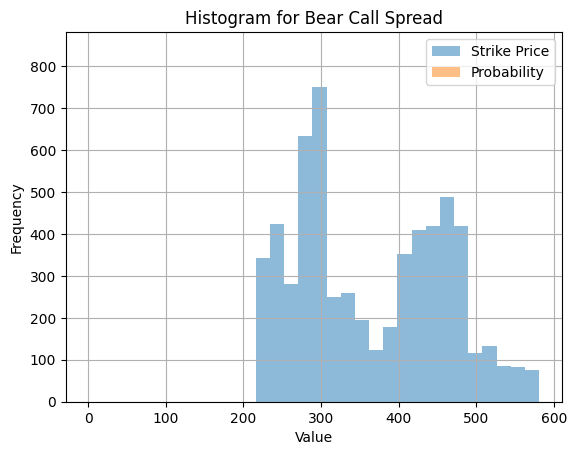

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming dataframes bear_call_spread, bull_put_ladder, bull_put_spread, bear_call_ladder are already loaded

# 1. Summary Statistics
def summary_stats(data):
    return data.describe()

# 2. Plot Histograms of Strike Prices and Probabilities
def plot_histograms(data, strategy_type):
    data['Strike Price'].hist(bins=20, alpha=0.5, label='Strike Price')
    data['Probability of Expiring Worthless'].hist(bins=20, alpha=0.5, label='Probability')
    plt.title(f'Histogram for {strategy_type}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# 3. Correlation Analysis for Ladder Strategies
def correlation_analysis(data, strategy_type):
    corr = data[['Lower Strike', 'Upper Strike']].corr()
    print(f'Correlation Matrix for {strategy_type}:\n', corr)

# 4. Plot Time-Series Analysis
def plot_time_series(data, strategy_type):
    data.plot(x='Date', y=['Strike Price', 'Probability of Expiring Worthless'])
    plt.title(f'Time-Series for {strategy_type}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

# Run analyses
print("Summary Statistics for Bear Call Spread:")
print(summary_stats(bear_call_spreads))

# print("\nSummary Statistics for Bull Put Ladder:")
# print(summary_stats(bull_put_ladder))

# print("\nSummary Statistics for Bull Put Spread:")
# print(summary_stats(bull_put_spread))

# print("\nSummary Statistics for Bear Call Ladder:")
# print(summary_stats(bear_call_ladder))

plot_histograms(bear_call_spreads, 'Bear Call Spread')
# plot_histograms(bull_put_spreads, 'Bull Put Spread')

# correlation_analysis(bull_put_ladders, 'Bull Put Ladder')
# correlation_analysis(bear_call_ladders, 'Bear Call Ladder')

# plot_time_series(bear_call_spreads, 'Bear Call Spread')
# plot_time_series(bull_put_ladders, 'Bull Put Ladder')


In [32]:
import pandas as pd
import numpy as np

class OptionsDataAnalyzer:
    """
    A class to analyze and process options data for various strategies.
    """
    def __init__(self, bear_call_spread_file, bull_put_ladder_file, bull_put_spread_file, bear_call_ladder_file):
        """
        Initialize the OptionsDataAnalyzer with file paths for different strategies.
        
        Parameters:
        bear_call_spread_file (str): Path to the CSV file for bear call spread data.
        bull_put_ladder_file (str): Path to the CSV file for bull put ladder data.
        bull_put_spread_file (str): Path to the CSV file for bull put spread data.
        bear_call_ladder_file (str): Path to the CSV file for bear call ladder data.
        """
        self.bear_call_spread = pd.read_csv(bear_call_spread_file)
        self.bull_put_ladder = pd.read_csv(bull_put_ladder_file)
        self.bull_put_spread = pd.read_csv(bull_put_spread_file)
        self.bear_call_ladder = pd.read_csv(bear_call_ladder_file)

    def fetch_historical_data(self, row):
        """
        Simulate fetching historical options data for a given row.
        In practice, this would fetch from an API or database.
        
        Parameters:
        row (pd.Series): A row from the DataFrame containing options data.
        
        Returns:
        dict: A dictionary containing historical data for the given row.
        """
        # Placeholder values
        underlying = "SPY"  # Simplification
        expiration_date = row['Date']  # Simplification
        premium = np.random.uniform(1, 5)  # Random premium value
        underlying_price = np.random.uniform(300, 500)  # Random underlying price
        profit_loss = premium * 100  # Simplification for profit/loss calculation
        
        return {
            "Underlying": underlying,
            "Expiration Date": expiration_date,
            "Premium": premium,
            "Underlying Price": underlying_price,
            "Profit/Loss": profit_loss
        }

    def add_historical_data(self, df):
        """
        Add historical options data to the DataFrame.
        
        Parameters:
        df (pd.DataFrame): DataFrame containing options data.
        
        Returns:
        pd.DataFrame: DataFrame with added historical data.
        """
        historical_data = df.apply(self.fetch_historical_data, axis=1, result_type='expand')
        return pd.concat([df, historical_data], axis=1)

    def analyze_data(self):
        """
        Analyze and return data with added historical context.
        
        Returns:
        dict: A dictionary containing DataFrames with added historical data for each strategy.
        """
        self.bear_call_spread = self.add_historical_data(self.bear_call_spread)
        self.bull_put_ladder = self.add_historical_data(self.bull_put_ladder)
        self.bull_put_spread = self.add_historical_data(self.bull_put_spread)
        self.bear_call_ladder = self.add_historical_data(self.bear_call_ladder)
        
        return {
            'Bear Call Spread': self.bear_call_spread,
            'Bull Put Ladder': self.bull_put_ladder,
            'Bull Put Spread': self.bull_put_spread,
            'Bear Call Ladder': self.bear_call_ladder
        }

# Paths to the CSV files (assuming they are uploaded and accessible)
bear_call_spread_file = './bear_call_spread.csv'
bull_put_ladder_file = './bull_put_ladder.csv'
bull_put_spread_file = './bull_put_spread.csv'
bear_call_ladder_file = './bear_call_ladder.csv'

# Initialize the analyzer with the file paths
analyzer = OptionsDataAnalyzer(bear_call_spread_file, bull_put_ladder_file, bull_put_spread_file, bear_call_ladder_file)

# Analyze the data
analyzed_data = analyzer.analyze_data()

# Example: Display the first few rows of the analyzed bear call spread data
# analyzed_data['Bear Call Spread'].tail()
# analyzed_data['Bear Call Ladder'].tail()
# Repeat the analysis for each strategy
for strategy_name, strategy_data in analyzed_data.items():
    print(f"Analyzing {strategy_name} strategy...")
    # Display the first few rows of the analyzed data for each strategy
    print(strategy_data.tail())
    print("\n")


Analyzing Bear Call Spread strategy...
            Date Spread Type  Strike Price  Probability of Expiring Worthless  \
6013  2024-08-29        bear         580.0                           0.269077   
6014  2024-08-29        bear         569.0                           0.388220   
6015  2024-08-30        bear         579.0                           0.336819   
6016  2024-08-30        bear         581.0                           0.315298   
6017  2024-08-30        bear         569.0                           0.452478   

     Underlying Expiration Date   Premium  Underlying Price  Profit/Loss  
6013        SPY      2024-08-29  4.302277        498.626541   430.227712  
6014        SPY      2024-08-29  3.107990        481.858900   310.798975  
6015        SPY      2024-08-30  4.076928        482.068375   407.692817  
6016        SPY      2024-08-30  1.418741        495.913661   141.874123  
6017        SPY      2024-08-30  2.875529        344.426933   287.552943  


Analyzing Bull Put Lad

In [12]:
def fetch_and_display_statistics(ticker, start_date, end_date, output='print', csv_path=None):
    # Fetch historical data
    df = yf.download(ticker, start=start_date, end=end_date)
    
    # Calculate Technical Indicators
    df['ATR'] = pd.concat([
        df['High'] - df['Low'],
        np.abs(df['High'] - df['Close'].shift()),
        np.abs(df['Low'] - df['Close'].shift())
    ], axis=1).max(axis=1).rolling(window=14).mean()
    
    delta = df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    df['RSI'] = 100 - (100 / (1 + gain / loss))
    
    df['20 Day MA'] = df['Close'].rolling(window=20).mean()
    df['20 Day STD'] = df['Close'].rolling(window=20).std()
    df['Upper Band'] = df['20 Day MA'] + 2 * df['20 Day STD']
    df['Lower Band'] = df['20 Day MA'] - 2 * df['20 Day STD']
    
    df['tenkan_sen'] = (df['High'].rolling(window=9).max() + df['Low'].rolling(window=9).min()) / 2
    df['kijun_sen'] = (df['High'].rolling(window=26).max() + df['Low'].rolling(window=26).min()) / 2
    df['senkou_span_a'] = ((df['tenkan_sen'] + df['kijun_sen']) / 2).shift(26)
    df['senkou_span_b'] = ((df['High'].rolling(window=52).max() + df['Low'].rolling(window=52).min()) / 2).shift(26)
    df['chikou_span'] = df['Close'].shift(-26)
    
    # Resample data to monthly
    df_monthly = df.resample('M').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum',
        'ATR': 'mean',
        'RSI': 'mean',
        '20 Day MA': 'mean',
        'Upper Band': 'mean',
        'Lower Band': 'mean',
        'tenkan_sen': 'mean',
        'kijun_sen': 'mean',
        'senkou_span_a': 'mean',
        'senkou_span_b': 'mean',
        'chikou_span': 'mean'
    })
    
    df_monthly['Return'] = df_monthly['Close'].pct_change() * 100
    
    # Generate statistics
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    statistics = []

    for month in range(1, 13):
        monthly_data = df_monthly[df_monthly.index.month == month]
        if monthly_data.empty:
            continue

        monthly_stats = {
            'Month': months[month-1],
            'Mean Return (%)': monthly_data['Return'].mean(),
            'Std Return (%)': monthly_data['Return'].std(),
            'Highest Return (%)': monthly_data['Return'].max(),
            'Highest Return Year': monthly_data['Return'].idxmax().year,
            'Lowest Return (%)': monthly_data['Return'].min(),
            'Lowest Return Year': monthly_data['Return'].idxmin().year,
            'Mean Volume': monthly_data['Volume'].mean(),
            'Highest Volume': monthly_data['Volume'].max(),
            'Highest Volume Year': monthly_data['Volume'].idxmax().year,
            'Lowest Volume': monthly_data['Volume'].min(),
            'Lowest Volume Year': monthly_data['Volume'].idxmin().year,
            'Mean ATR': monthly_data['ATR'].mean(),
            'Mean RSI': monthly_data['RSI'].mean(),
            'Mean 20 Day MA': monthly_data['20 Day MA'].mean(),
            'Mean Upper Band': monthly_data['Upper Band'].mean(),
            'Mean Lower Band': monthly_data['Lower Band'].mean(),
            'Mean Tenkan-sen': monthly_data['tenkan_sen'].mean(),
            'Mean Kijun-sen': monthly_data['kijun_sen'].mean(),
            'Mean Senkou Span A': monthly_data['senkou_span_a'].mean(),
            'Mean Senkou Span B': monthly_data['senkou_span_b'].mean(),
            'Mean Chikou Span': monthly_data['chikou_span'].mean(),
            'Close > RSI Days': (monthly_data['Close'] > monthly_data['RSI']).sum(),
            'Close > Upper Band Days': (monthly_data['Close'] > monthly_data['Upper Band']).sum(),
            'High > ATR Days': (monthly_data['High'] > monthly_data['ATR']).sum()
        }

        statistics.append(monthly_stats)

    df_statistics = pd.DataFrame(statistics)

    # Output based on the selected option
    if output == 'print':
        for index, row in df_statistics.iterrows():
            print(f"{ticker} - {row['Month']} Statistics")
            print(f"Mean {row['Month']} Return: {row['Mean Return (%)']:.2f}%")
            print(f"Standard Deviation of {row['Month']} Returns: {row['Std Return (%)']:.2f}%")
            print(f"Highest {row['Month']} Return: {row['Highest Return (%)']:.2f}% in {row['Highest Return Year']}")
            print(f"Lowest {row['Month']} Return: {row['Lowest Return (%)']:.2f}% in {row['Lowest Return Year']}")
            print(f"Mean {row['Month']} Volume: {row['Mean Volume']:.2f}")
            print(f"Highest {row['Month']} Volume: {row['Highest Volume']:.2f} in {row['Highest Volume Year']}")
            print(f"Lowest {row['Month']} Volume: {row['Lowest Volume']:.2f} in {row['Lowest Volume Year']}")
            print(f"Mean {row['Month']} ATR: {row['Mean ATR']:.2f}")
            print(f"Mean {row['Month']} RSI: {row['Mean RSI']:.2f}")
            print(f"Mean {row['Month']} 20 Day MA: {row['Mean 20 Day MA']:.2f}")
            print(f"Mean {row['Month']} Upper Band: {row['Mean Upper Band']:.2f}")
            print(f"Mean {row['Month']} Lower Band: {row['Mean Lower Band']:.2f}")
            print(f"Mean {row['Month']} Tenkan-sen: {row['Mean Tenkan-sen']:.2f}")
            print(f"Mean {row['Month']} Kijun-sen: {row['Mean Kijun-sen']:.2f}")
            print(f"Mean {row['Month']} Senkou Span A: {row['Mean Senkou Span A']:.2f}")
            print(f"Mean {row['Month']} Senkou Span B: {row['Mean Senkou Span B']:.2f}")
            print(f"Mean {row['Month']} Chikou Span: {row['Mean Chikou Span']:.2f}")
            print(f"Number of days Close > RSI in {row['Month']}: {row['Close > RSI Days']}")
            print(f"Number of days Close > Upper Bollinger Band in {row['Month']}: {row['Close > Upper Band Days']}")
            print(f"Number of days High > ATR in {row['Month']}: {row['High > ATR Days']}")
            print()

    elif output == 'csv':
        if csv_path is None:
            raise ValueError("CSV path must be provided if output is set to 'csv'")
        df_statistics.to_csv(csv_path, index=False)
        print(f"Statistics exported to {csv_path}")
    
    elif output == 'df':
        return df_statistics

# Examples of usage:

# 1. Print the monthly statistics
fetch_and_display_statistics('SPY', '2020-01-01', '2023-01-01', output='print')

# 2. Export the monthly statistics to a CSV file
fetch_and_display_statistics('SPY', '2020-01-01', '2023-01-01', output='csv', csv_path='SPY_monthly_statistics.csv')

# 3. Return the monthly statistics as a DataFrame
df_stats = fetch_and_display_statistics('SPY', '2020-01-01', '2023-01-01', output='df')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

SPY - Jan Statistics
Mean Jan Return: -3.15%
Standard Deviation of Jan Returns: 3.01%
Highest Jan Return: -1.02% in 2021
Lowest Jan Return: -5.27% in 2022
Mean Jan Volume: 1759812333.33
Highest Jan Volume: 2485167800.00 in 2022
Lowest Jan Volume: 1392003800.00 in 2020
Mean Jan ATR: 4.76
Mean Jan RSI: 51.61
Mean Jan 20 Day MA: 389.13
Mean Jan Upper Band: 400.40
Mean Jan Lower Band: 377.86
Mean Jan Tenkan-sen: 387.67
Mean Jan Kijun-sen: 416.15
Mean Jan Senkou Span A: 409.88
Mean Jan Senkou Span B: 397.89
Mean Jan Chikou Span: 379.68
Number of days Close > RSI in Jan: 3
Number of days Close > Upper Bollinger Band in Jan: 0
Number of days High > ATR in Jan: 3

SPY - Feb Statistics
Mean Feb Return: -2.70%
Standard Deviation of Feb Returns: 5.35%
Highest Feb Return: 2.78% in 2021
Lowest Feb Return: -7.92% in 2020
Mean Feb Volume: 1905332066.67
Highest Feb Volume: 2297975100.00 in 2022
Lowest Feb Volume: 1307806200.00 in 2021
Mean Feb ATR: 6.14
Mean Feb RSI: 52.06
Mean Feb 20 Day MA: 386.60
M

# Macro & Fundemental 

[*********************100%***********************]  1 of 1 completed


Merged Data:
                   Open        High         Low       Close  Adj Close  \
2010-03-31  116.949997  117.519997  116.610001  117.000000  89.752617   
2010-04-30  120.879997  121.010002  118.779999  118.809998  91.141090   
2010-06-30  103.919998  104.879997  102.879997  103.220001  79.558479   
2010-08-31  104.919998  105.980003  104.489998  105.309998  81.169380   
2010-09-30  115.050003  115.790001  113.589996  114.129997  88.438461   

               Volume   20 Day MA  20 Day STD  Upper Band  Lower Band  \
2010-03-31  161078700  115.965000    1.309297  118.583594  113.346405   
2010-04-30  270000900  119.947500    1.091377  122.130253  117.764746   
2010-06-30  284101700  108.616001    2.672532  113.961064  103.270937   
2010-08-31  273933100  108.708500    2.756067  114.220634  103.196365   
2010-09-30  287106700  112.663500    1.682035  116.027571  109.299429   

                  RSI      MACD  Signal Line  FEDFUNDS  
2010-03-31  62.360462  1.386369     1.456042      0

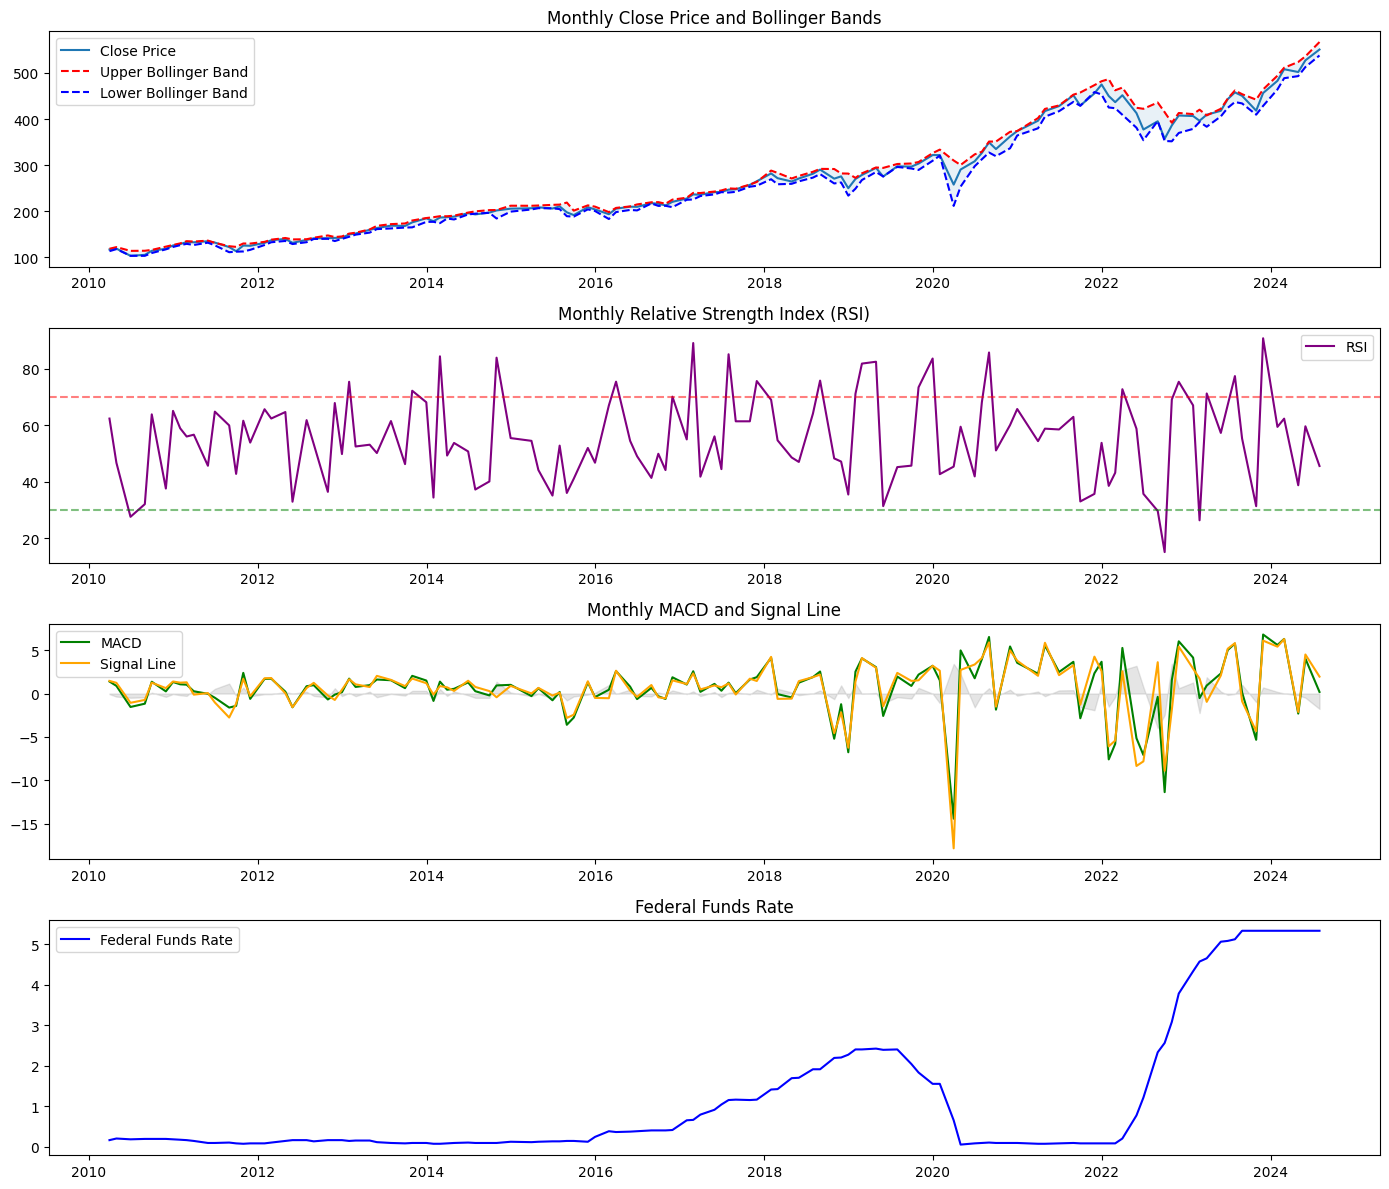

In [13]:
def process_financial_macro_data(ticker, macro_series, start_date='2008-01-01', end_date=None, plot=True):
    """
    Fetch financial and macroeconomic data, merge, and optionally plot the data.
    """
    # Set end date if not provided
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    # Fetch financial data
    financial_df = yf.download(ticker, start=start_date, end=end_date)
    
    # Fetch macroeconomic data from FRED
    macro_df = pdr.get_data_fred(macro_series, start=start_date)
    macro_df = macro_df.resample('M').ffill()  # Ensure macro data is monthly

    # Calculate technical indicators
    financial_df['20 Day MA'] = financial_df['Close'].rolling(window=20).mean()
    financial_df['20 Day STD'] = financial_df['Close'].rolling(window=20).std()
    financial_df['Upper Band'] = financial_df['20 Day MA'] + 2 * financial_df['20 Day STD']
    financial_df['Lower Band'] = financial_df['20 Day MA'] - 2 * financial_df['20 Day STD']
    
    delta = financial_df['Close'].diff()
    gain = delta.clip(lower=0).rolling(window=14).mean()
    loss = -delta.clip(upper=0).rolling(window=14).mean()
    financial_df['RSI'] = 100 - (100 / (1 + gain / loss))
    
    financial_df['MACD'] = financial_df['Close'].ewm(span=12, adjust=False).mean() - financial_df['Close'].ewm(span=26, adjust=False).mean()
    financial_df['Signal Line'] = financial_df['MACD'].ewm(span=9, adjust=False).mean()

    # Merge financial and macroeconomic data
    merged_df = financial_df.merge(macro_df, left_index=True, right_index=True, how='inner')
    print("Merged Data:\n", merged_df.head())

    # Plot data if requested
    if plot:
        fig, axs = plt.subplots(4, 1, figsize=(14, 12))

        # Plot Close Price and Bollinger Bands
        axs[0].plot(merged_df['Close'], label='Close Price')
        axs[0].plot(merged_df['Upper Band'], label='Upper Bollinger Band', linestyle='--', color='r')
        axs[0].plot(merged_df['Lower Band'], label='Lower Bollinger Band', linestyle='--', color='b')
        axs[0].fill_between(merged_df.index, merged_df['Upper Band'], merged_df['Lower Band'], alpha=0.1)
        axs[0].set_title('Monthly Close Price and Bollinger Bands')
        axs[0].legend()

        # Plot RSI
        axs[1].plot(merged_df['RSI'], label='RSI', color='purple')
        axs[1].axhline(70, linestyle='--', alpha=0.5, color='r')
        axs[1].axhline(30, linestyle='--', alpha=0.5, color='g')
        axs[1].set_title('Monthly Relative Strength Index (RSI)')
        axs[1].legend()

        # Plot MACD
        axs[2].plot(merged_df['MACD'], label='MACD', color='g')
        axs[2].plot(merged_df['Signal Line'], label='Signal Line', color='orange')
        axs[2].fill_between(merged_df.index, merged_df['MACD'] - merged_df['Signal Line'], 0, alpha=0.2, color='grey')
        axs[2].set_title('Monthly MACD and Signal Line')
        axs[2].legend()

        # Plot Fed Funds Rate
        axs[3].plot(merged_df[macro_series], label='Federal Funds Rate', color='blue')
        axs[3].set_title('Federal Funds Rate')
        axs[3].legend()

        plt.tight_layout()
        plt.show()

    return merged_df

# Example usage:

# Fetch, merge, and plot financial data with Fed Funds Rate
merged_data = process_financial_macro_data(ticker='SPY', macro_series='FEDFUNDS', start_date='2010-01-01', plot=True)


# Display Monthly Seasonality

[*********************100%***********************]  1 of 1 completed


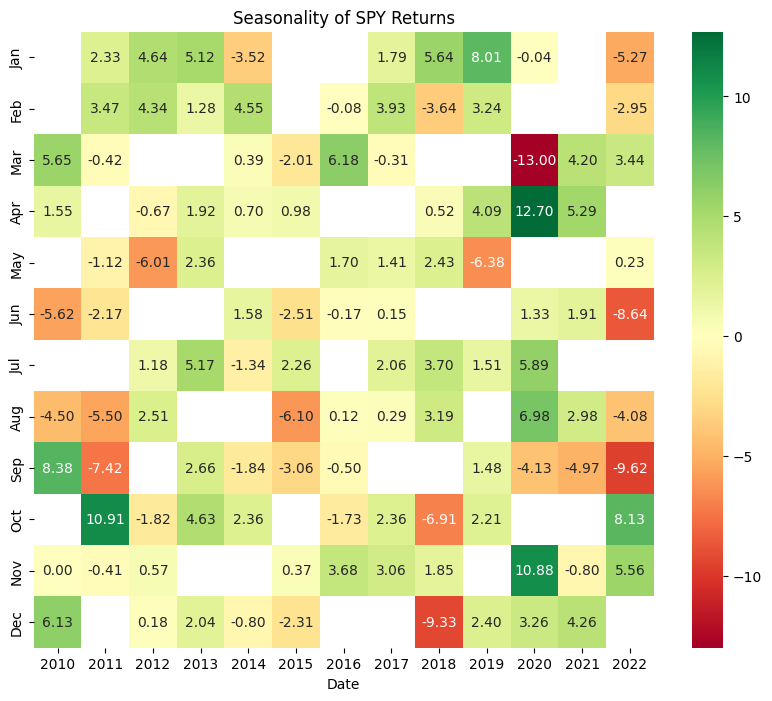

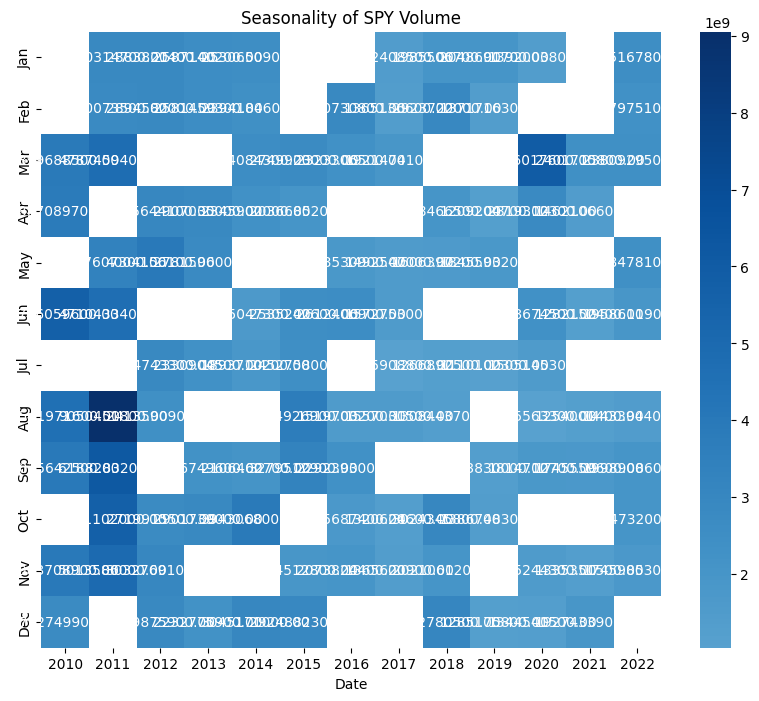

Seasonality Data for SPY:
Date      2010       2011      2012      2013      2014      2015      2016  \
Jan        NaN   2.330014  4.637456  5.119018 -3.524831       NaN       NaN   
Feb        NaN   3.473734  4.340540  1.275888  4.551578       NaN -0.082595   
Mar   5.652883  -0.420576       NaN       NaN  0.386495 -2.007980  6.178966   
Apr   1.547006        NaN -0.667568  1.921232  0.695152  0.983391       NaN   
May        NaN  -1.121453 -6.005572  2.360975       NaN       NaN  1.701156   
Jun  -5.623115  -2.171974       NaN       NaN  1.577750 -2.505443 -0.171560   
Jul        NaN        NaN  1.182954  5.167690 -1.343759  2.258923       NaN   
Aug  -4.498050  -5.497565  2.505262       NaN       NaN -6.095013  0.119754   
Sep   8.375273  -7.421044       NaN  2.664223 -1.838475 -3.055594 -0.496827   
Oct        NaN  10.914713 -1.819820  4.630676  2.355090       NaN -1.733703   
Nov   0.000000  -0.406376  0.565962       NaN       NaN  0.365512  3.683840   
Dec   6.127101        NaN 

[*********************100%***********************]  1 of 1 completed


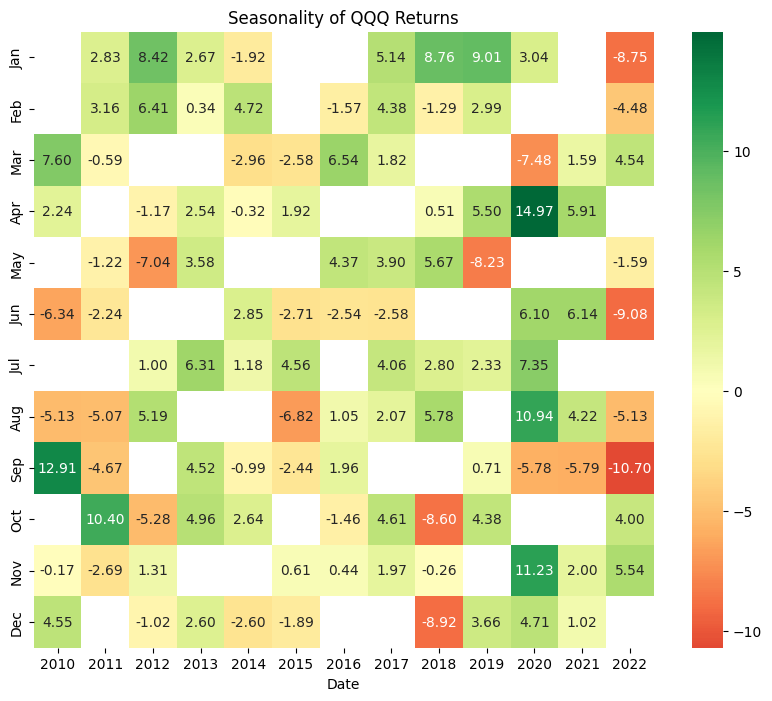

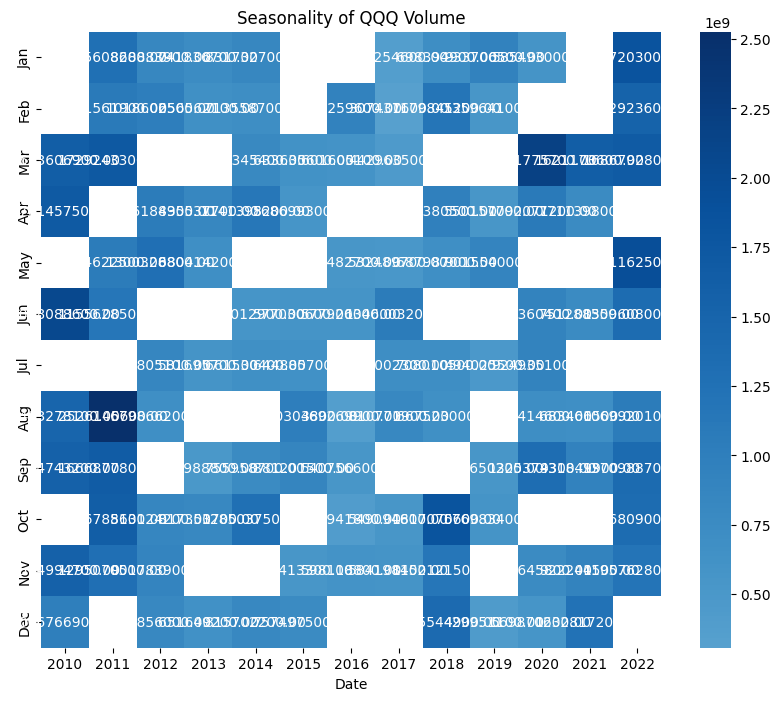

[*********************100%***********************]  1 of 1 completed

Data exported to seasonality_data/QQQ_seasonality_returns.csv and seasonality_data/QQQ_seasonality_volume.csv
Processing data for SPY...


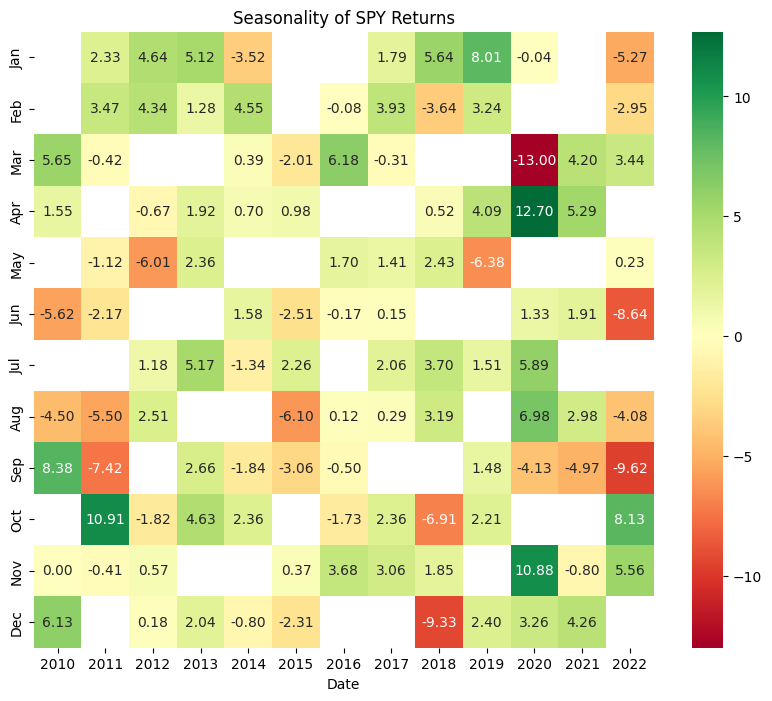

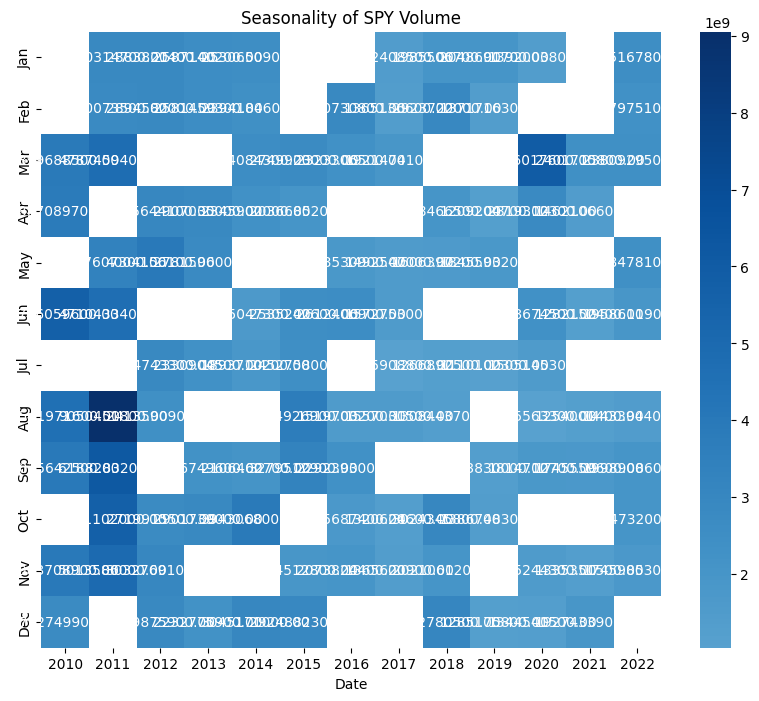

[*********************100%***********************]  1 of 1 completed

Processing data for QQQ...


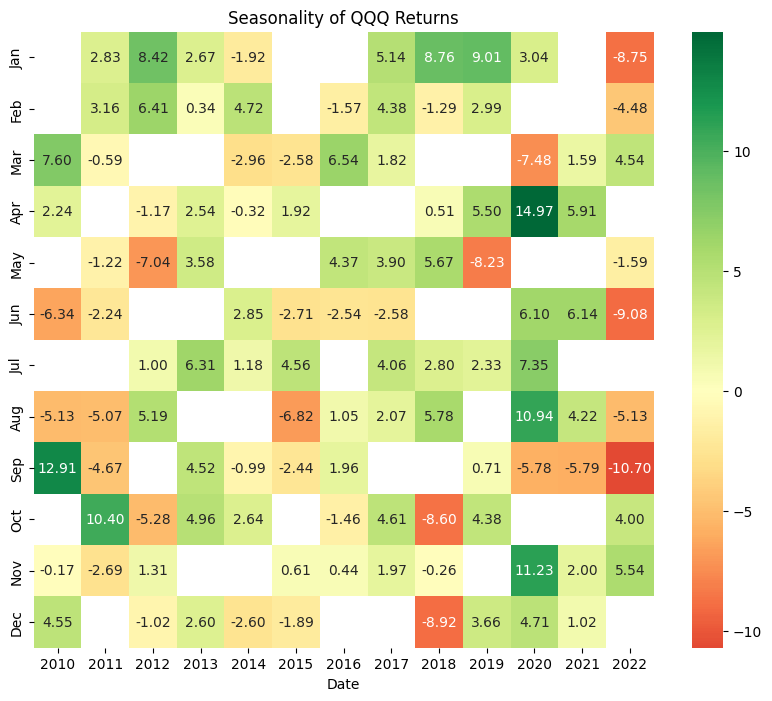

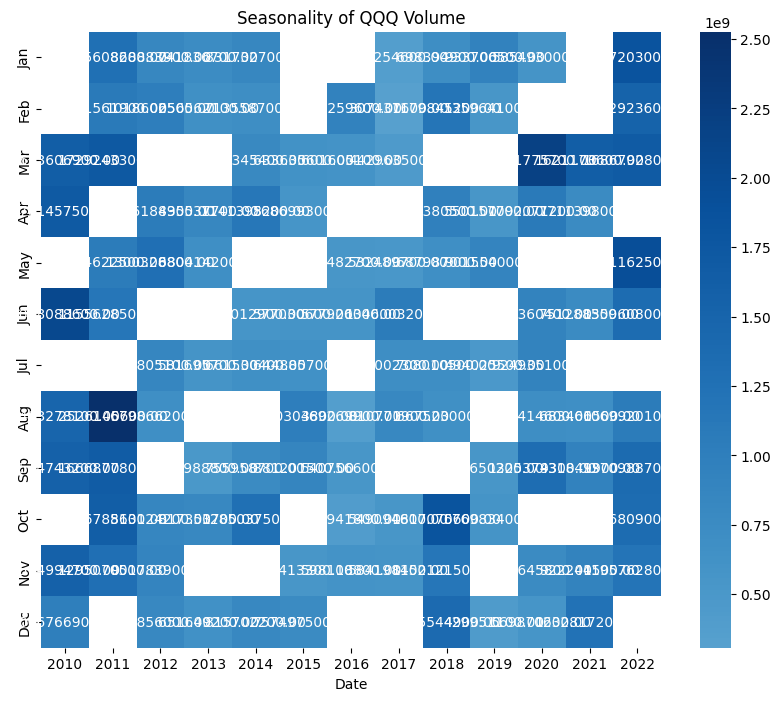

[*********************100%***********************]  1 of 1 completed

Processing data for DOW...


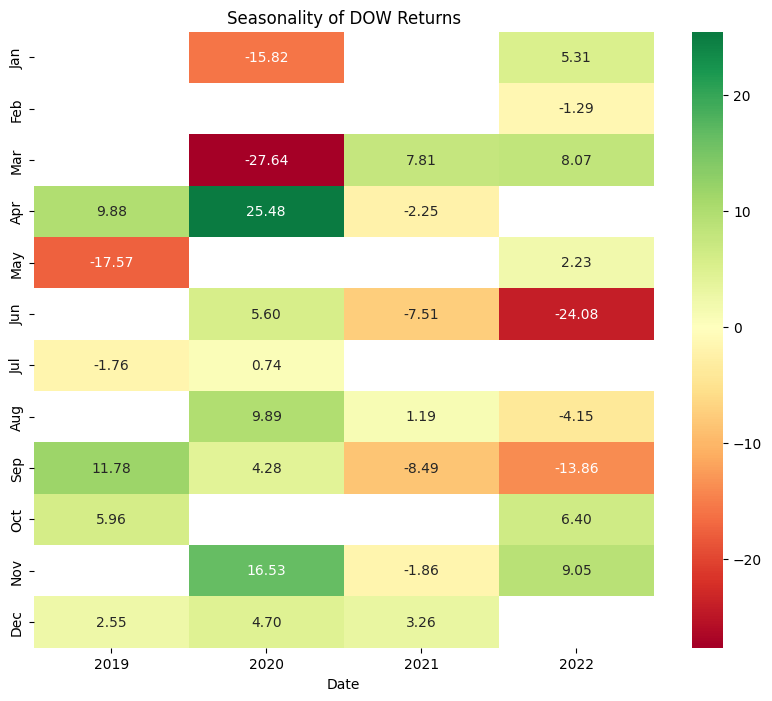

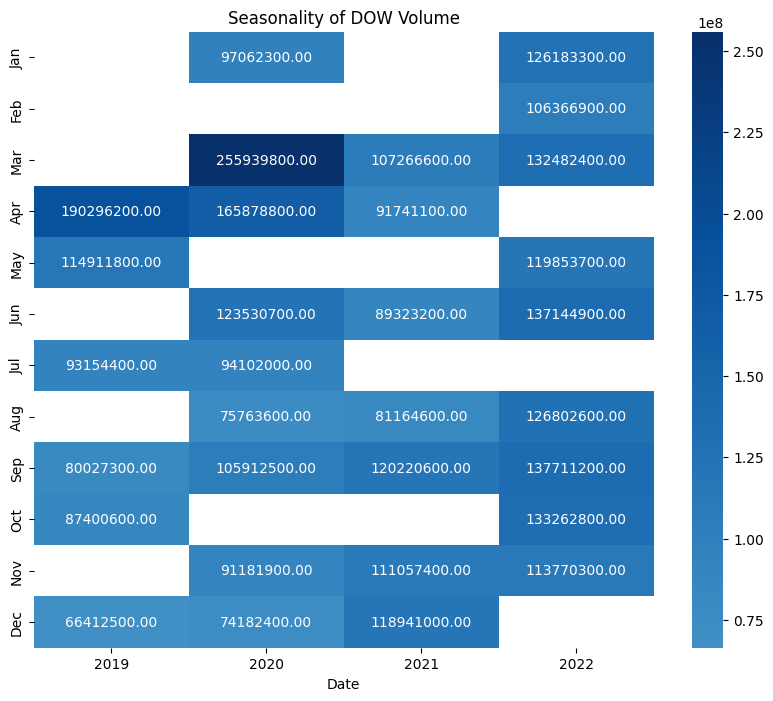

[*********************100%***********************]  1 of 1 completed

Processing data for SPYD...


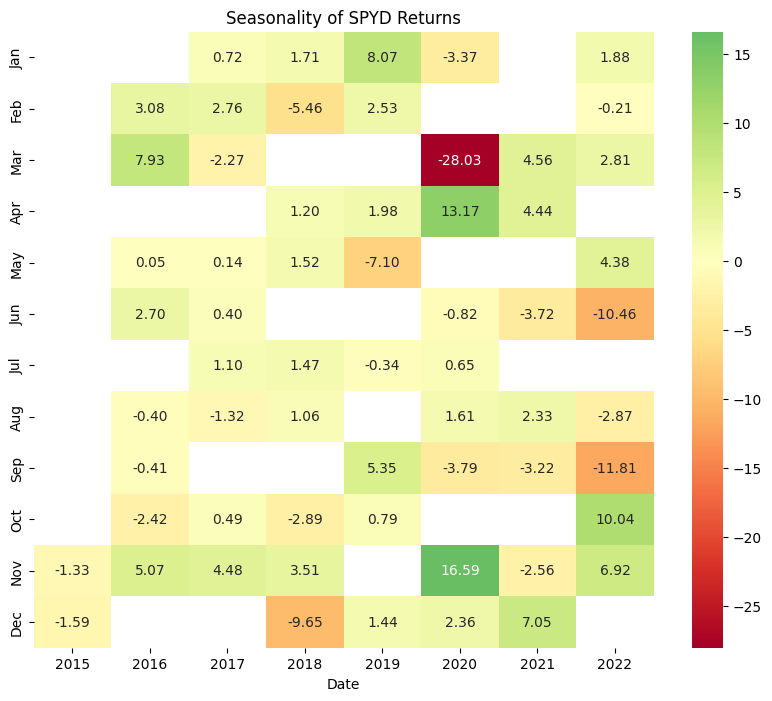

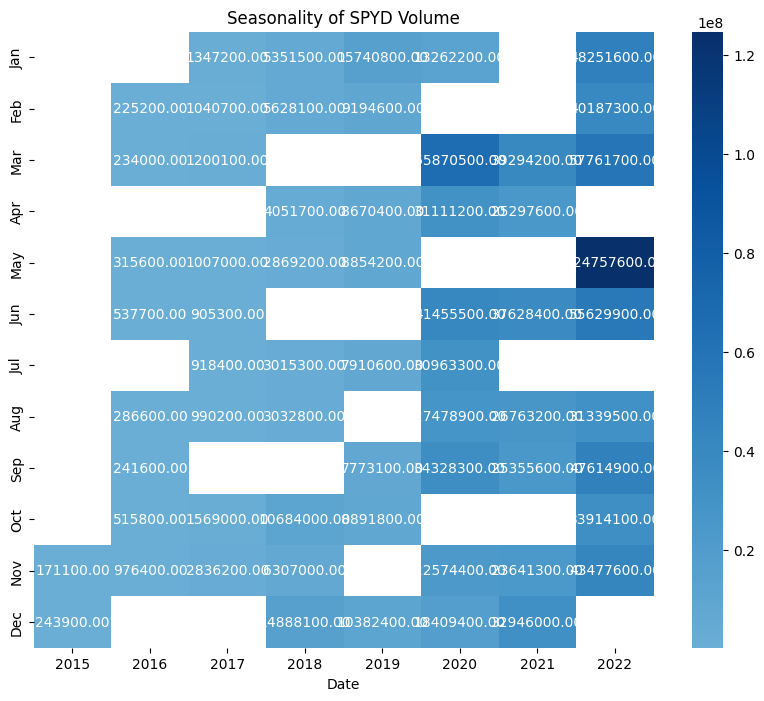

In [14]:
def process_ticker_data(ticker='SPY', start='2008-01-01', end=None, period='M', output='print', csv_path=None):
    """
    Load data, calculate returns, perform seasonality analysis, visualize, and optionally save or return data.
    """
    # Set end date if not provided
    if end is None:
        end = datetime.now().strftime('%Y-%m-%d')
    
    # Load data
    df = yf.download(ticker, start=start, end=end)
    
    # Calculate percentage returns and resample
    df['Return'] = df['Close'].resample(period).ffill().pct_change() * 100
    df['Volume'] = df['Volume'].resample(period).sum()
    
    # Create seasonality table
    seasonality_table = df.pivot_table(values='Return', index=df.index.year, columns=df.index.month, aggfunc=np.mean)
    seasonality_volume_table = df.pivot_table(values='Volume', index=df.index.year, columns=df.index.month, aggfunc=np.mean)
    
    # Ensure all months are represented
    seasonality_table = seasonality_table.reindex(columns=range(1, 13))
    seasonality_volume_table = seasonality_volume_table.reindex(columns=range(1, 13))
    
    # Rename columns for better readability
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    seasonality_table.columns = month_names
    seasonality_volume_table.columns = month_names
    
    # Transpose the table for better readability
    seasonality_table = seasonality_table.transpose()
    seasonality_volume_table = seasonality_volume_table.transpose()

    # Visualize the seasonality table
    plt.figure(figsize=(10, 8))
    sns.heatmap(seasonality_table, annot=True, fmt=".2f", cmap='RdYlGn', center=0)
    plt.title(f'Seasonality of {ticker} Returns')
    plt.show()
    
    # Visualize the volume seasonality table
    plt.figure(figsize=(10, 8))
    sns.heatmap(seasonality_volume_table, annot=True, fmt=".2f", cmap='Blues', center=0)
    plt.title(f'Seasonality of {ticker} Volume')
    plt.show()

    # Optionally output data
    if output == 'print':
        print(f"Seasonality Data for {ticker}:")
        print(seasonality_table)
        print(f"\nSeasonality Volume Data for {ticker}:")
        print(seasonality_volume_table)
    elif output == 'csv':
        if csv_path is None:
            raise ValueError("CSV path must be provided if output is set to 'csv'")
        seasonality_table.to_csv(f"{csv_path}_returns.csv")
        seasonality_volume_table.to_csv(f"{csv_path}_volume.csv")
        print(f"Data exported to {csv_path}_returns.csv and {csv_path}_volume.csv")
    elif output == 'df':
        return seasonality_table, seasonality_volume_table


# Examples of usage:

# 1. Process data for a single ticker, print the results
process_ticker_data(ticker='SPY', start='2010-01-01', end='2023-01-01', output='print')

# 2. Process data for a single ticker and save the results to CSV files
process_ticker_data(ticker='QQQ', start='2010-01-01', end='2023-01-01', output='csv', csv_path='seasonality_data/QQQ_seasonality')

# 3. Process data for multiple tickers and return the results as DataFrames
tickers = ['SPY', 'QQQ', 'DOW', 'SPYD']
for ticker in tickers:
    print(f"Processing data for {ticker}...")
    returns_df, volume_df = process_ticker_data(ticker=ticker, start='2010-01-01', end='2023-01-01', output='df')
    # Additional custom analysis could be done with the returned DataFrames


# 52 Week Seasonality with Kelly Method

In [15]:
def visualize_weekly_seasonality(tickers, start_date, end_date, triple_witching_weeks):
    """
    Visualizes the 52-week seasonality of a list of tickers.

    Parameters:
    tickers (list): List of ticker symbols to analyze.
    start_date (str): Start date for the historical data in "YYYY-MM-DD" format.
    end_date (str): End date for the historical data in "YYYY-MM-DD" format.
    triple_witching_weeks (list): List of week numbers that represent triple witching weeks.
    """
    
    # Download historical data for all tickers
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

    for ticker in tickers:
        # Calculate weekly returns and volume statistics
        df = data[ticker].copy()
        df['Return'] = df['Adj Close'].pct_change()
        df['Week_Number'] = df.index.isocalendar().week
        df['Year'] = df.index.year
        df['Ticker'] = ticker

        # Group data by year and week number
        weekly_data = df.groupby(['Year', 'Week_Number']).agg({
            'Return': 'sum',
            'Volume': 'mean'
        }).reset_index()
        weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

        # Pivot the data for heatmap creation
        pivot_data = weekly_data.pivot(index="Week", columns="Year", values="Return")

        # Plot the heatmap with enhanced contrast and triple witching weeks highlighted
        plt.figure(figsize=(14, 8))
        sns.heatmap(pivot_data, annot=False, fmt=".2f", cmap="coolwarm", center=0, linewidths=.5, 
                    cbar_kws={'label': 'Weekly Return'})

        # Highlight Triple Witching Weeks
        for week in triple_witching_weeks:
            plt.axhline(y=week-0.5, color='yellow', linewidth=2)

        plt.title(f'Seasonality of {ticker} Returns')
        plt.show()


In [16]:
def export_weekly_seasonality_data(tickers, start_date, end_date, odds_ratio=2, output_dir='seasonality_data'):
    """
    Exports the 52-week seasonality data of a list of tickers to CSV files.

    Parameters:
    tickers (list): List of ticker symbols to analyze.
    start_date (str): Start date for the historical data in "YYYY-MM-DD" format.
    end_date (str): End date for the historical data in "YYYY-MM-DD" format.
    odds_ratio (float): The odds ratio for calculating the Kelly Ratio. Default is 2:1.
    output_dir (str): Directory where the CSV files will be saved.
    """
    
    # Create the output directory if it doesn't exist
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Download historical data for all tickers
    data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')

    for ticker in tickers:
        # Calculate weekly returns and volume statistics
        df = data[ticker].copy()
        df['Return'] = df['Adj Close'].pct_change()
        df['Week_Number'] = df.index.isocalendar().week
        df['Year'] = df.index.year
        df['Ticker'] = ticker

        # Group data by year and week number
        weekly_data = df.groupby(['Year', 'Week_Number']).agg({
            'Return': 'sum',
            'Volume': 'mean'
        }).reset_index()
        weekly_data['Week'] = weekly_data['Week_Number'].astype(int)

        # Calculate additional metrics
        volatility = weekly_data.groupby('Week')['Return'].std().reset_index(name='Volatility')
        positive_returns = weekly_data.groupby('Week')['Return'].apply(lambda x: (x > 0).mean()).reset_index(name='Positive_Returns')

        # Calculate Kelly Ratio
        kelly_ratio = (positive_returns['Positive_Returns'] * odds_ratio - 1) / odds_ratio
        weekly_data = weekly_data.merge(volatility, on='Week')
        weekly_data = weekly_data.merge(positive_returns, on='Week')
        weekly_data['Kelly_Ratio'] = kelly_ratio

        # Save the DataFrame to a CSV file
        output_path = os.path.join(output_dir, f'{ticker}_seasonality.csv')
        weekly_data.to_csv(output_path, index=False)
        print(f'Saved {ticker} seasonality data to {output_path}')


[*********************100%***********************]  6 of 6 completed


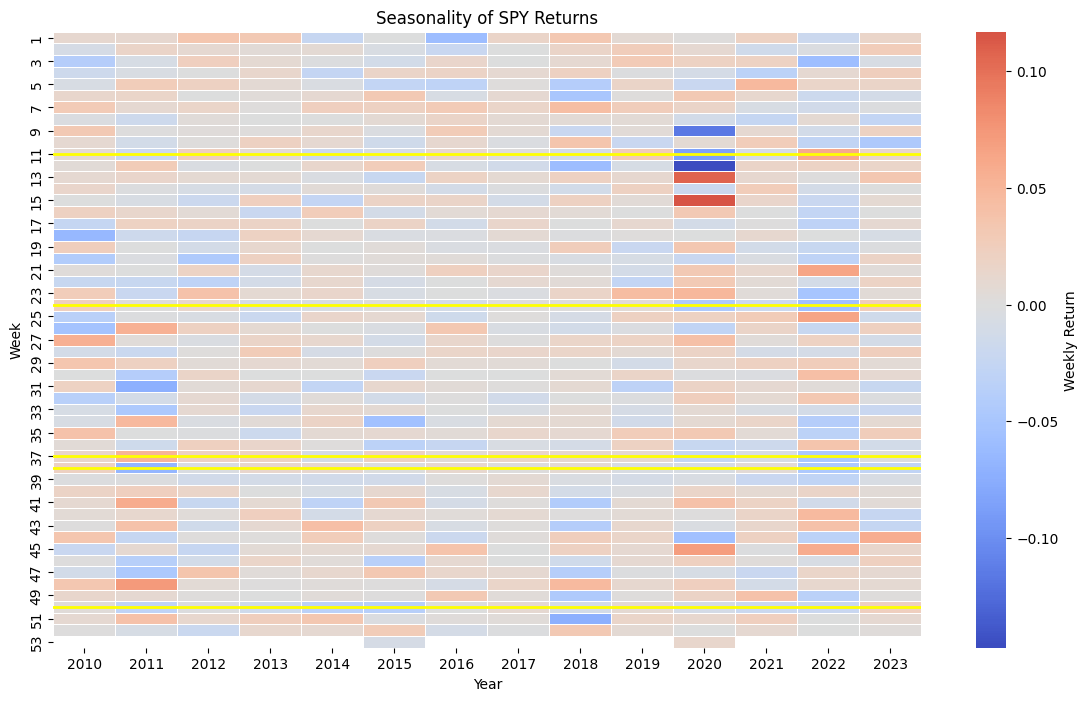

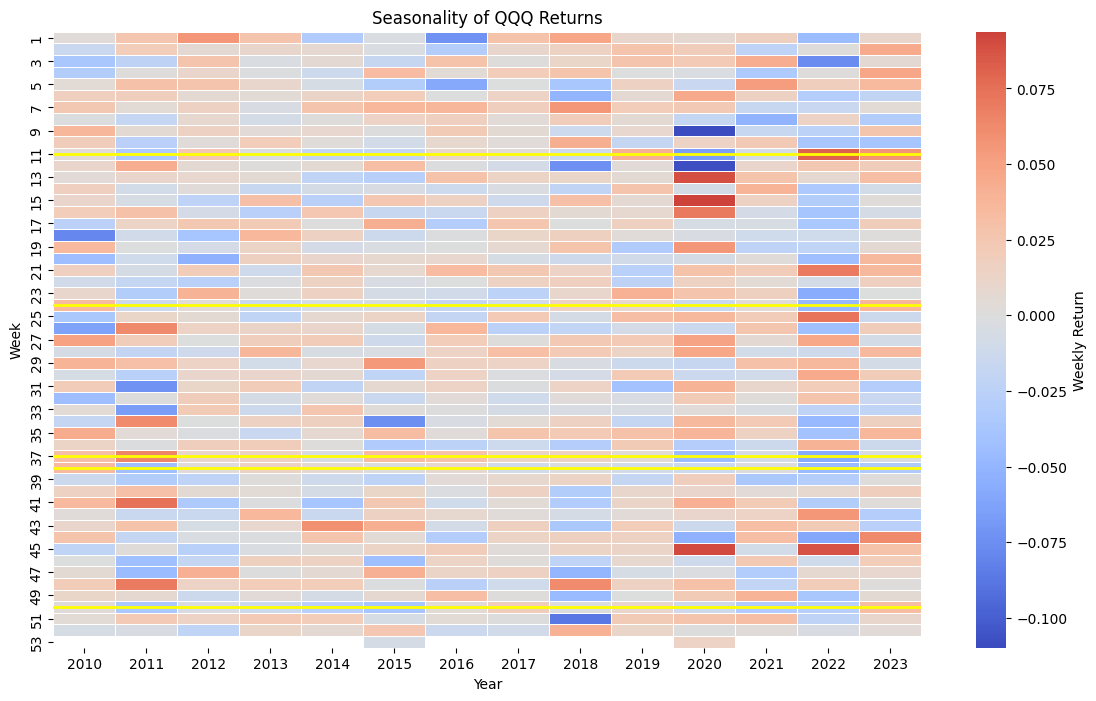

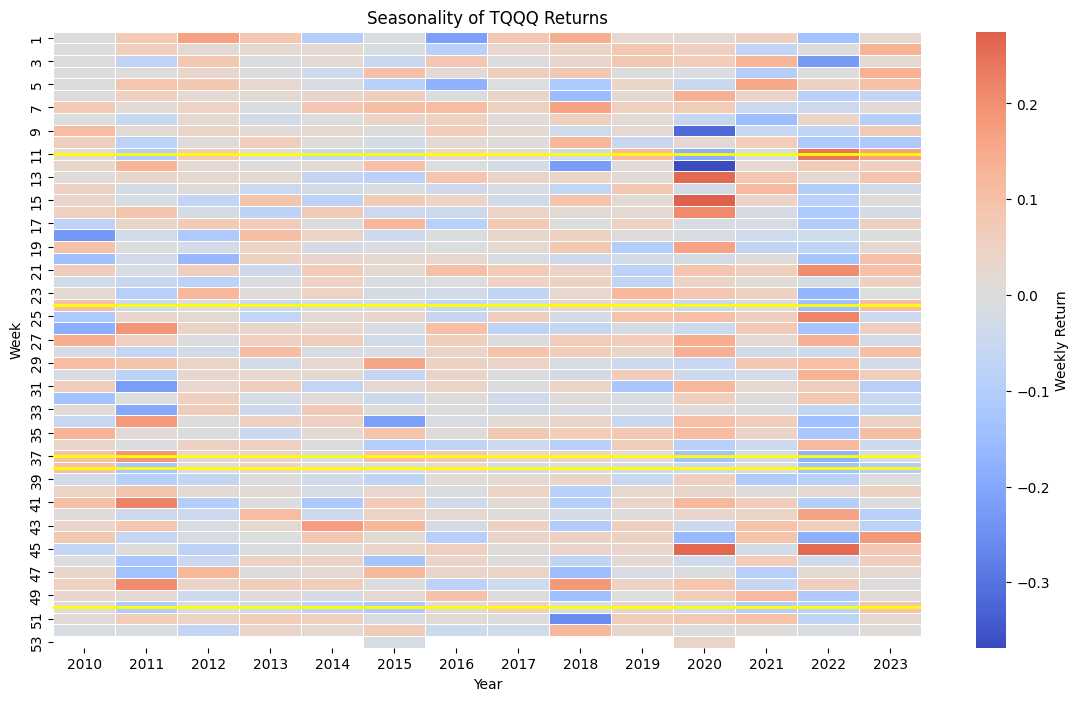

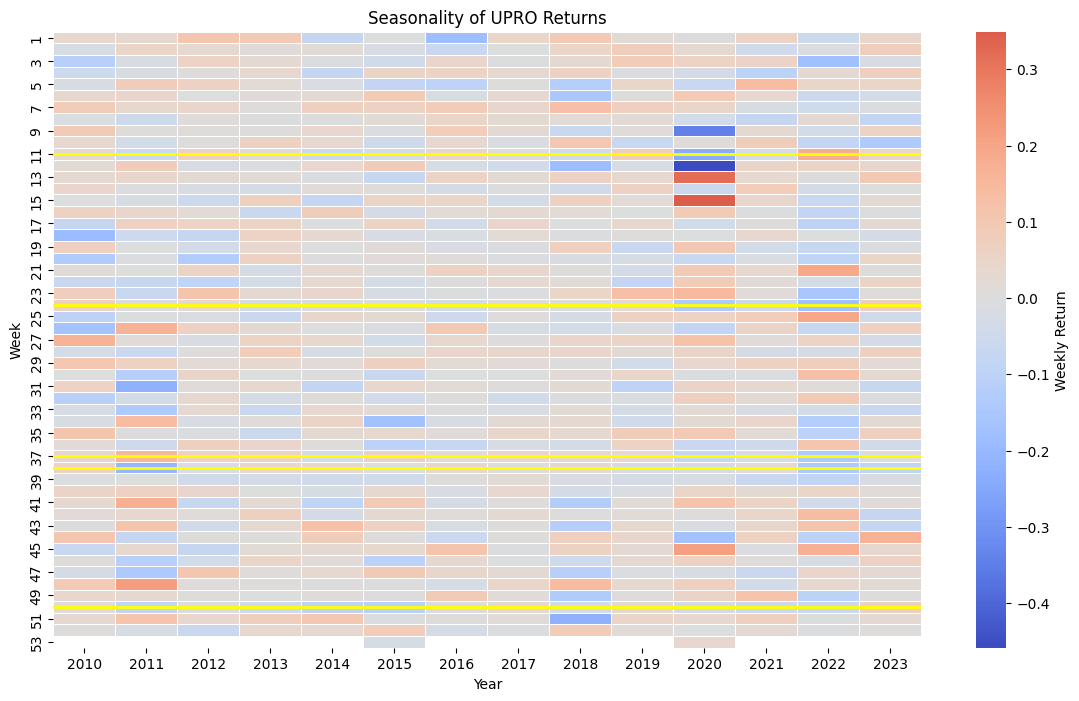

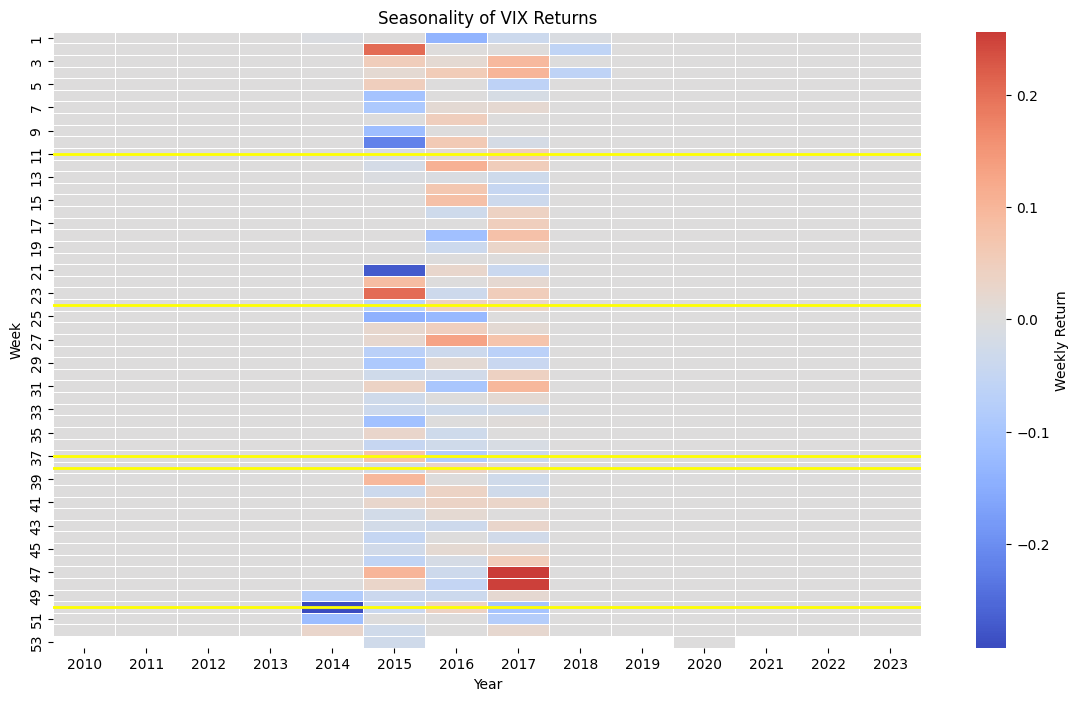

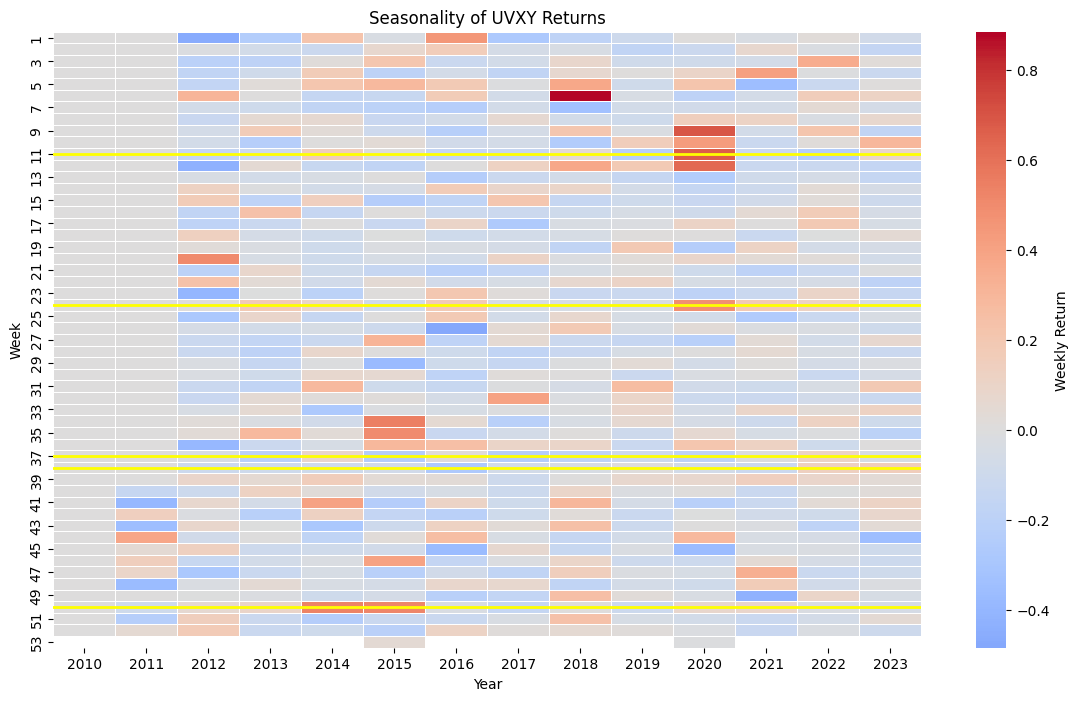

In [17]:
tickers = ["SPY", "QQQ", "TQQQ", "UPRO", "VIX","UVXY"]
triple_witching_weeks = [11, 24, 37, 38, 50]

# Visualize seasonality
visualize_weekly_seasonality(tickers, "2010-01-01", "2024-01-01", triple_witching_weeks)


In [18]:
# Export seasonality data to CSV
export_weekly_seasonality_data(tickers, "2010-01-01", "2024-01-01")

[*********************100%***********************]  6 of 6 completed

Saved SPY seasonality data to seasonality_data/SPY_seasonality.csv
Saved QQQ seasonality data to seasonality_data/QQQ_seasonality.csv
Saved TQQQ seasonality data to seasonality_data/TQQQ_seasonality.csv
Saved UPRO seasonality data to seasonality_data/UPRO_seasonality.csv
Saved VIX seasonality data to seasonality_data/VIX_seasonality.csv
Saved UVXY seasonality data to seasonality_data/UVXY_seasonality.csv


# intrepretation of 52 Week Seasonality (Referencing SPY_seasonality.csv)

### Week 1:
Week 1 presents several opportunities and risks across different assets:

- **SPY**: With a volatility of 2.57% and a high probability of positive returns (71.43%), SPY offers a strong foundation for a bullish position. The Kelly Ratio of 0.2143 supports a moderate investment size, making it suitable for selling bull put spreads. The highest return in 2012 and lowest in 2016 suggest that while the upside is promising, downside protection should not be neglected.

- **UPRO**: The leveraged nature of UPRO, with a volatility of 5.23% and a mean return of 1.45%, indicates potential for higher gains but also increased risk. Selling bullish put spreads on UPRO could be profitable, especially given the mean return, but the strategy should be paired with careful hedging using UVXY or VIX, given their historical performance.

- **UVXY**: UVXY’s high volatility of 18.34% and a negative mean return of -3.57% highlight its role as a hedge rather than a primary investment. Given the negative Kelly Ratio (-0.2143), a bearish call spread could be effective to capitalize on the high probability of negative returns. Alternatively, a bull call ladder could be used to take advantage of potential spikes in volatility while limiting risk.

- **VIX**: VIX shows similar characteristics to UVXY, with a moderate volatility of 11.29% and a mean return of -1.34%. A bear call spread might be appropriate here to benefit from the expected decline in volatility, especially as the Kelly Ratio is also negative.

- **Overall Strategy**: For Week 1, selling bull put spreads on UPRO and SPY appears to be a sound strategy, leveraging the relatively high probabilities of positive returns. To hedge against downside risks, consider a bearish call spread on UVXY, which typically benefits from increased market volatility. Additionally, a bear call spread on VIX could provide further protection against unexpected market moves, particularly if volatility declines as expected.

### Week 2:
Week 2 shows a continuation of moderate positive trends with some risk mitigation opportunities:

- **SPY**: With lower volatility (1.43%) and a positive return probability of 57.14%, SPY continues to offer a relatively stable investment. The Kelly Ratio is lower than in Week 1, suggesting a smaller position size. Selling bull put spreads could still be profitable, but with more conservative sizing. The standard deviation indicates less price fluctuation, making it a favorable week for collecting premium through options strategies.

- **UPRO**: Similar to SPY, UPRO’s mean return of 0.98% and a standard deviation of 2.94% indicate potential for gains, though with slightly higher risk. Given the volatility and historical return data, a bull put spread could again be effective, but it might be prudent to pair this with a short synthetic future to capitalize on potential downside while keeping upside potential.

- **UVXY**: UVXY’s high volatility (14.92%) and a negative mean return suggest this is another week where UVXY could serve as a hedge. A bear call spread could be deployed to benefit from expected declines in volatility. Given the negative Kelly Ratio, this is a clear indicator that UVXY may experience a downturn, making it suitable for hedging other positions.

- **VIX**: The VIX displays moderate volatility (10.57%) and a negative mean return, making it another candidate for bearish strategies. A bear call ladder could be an effective strategy, allowing participation in a declining volatility environment with limited risk.

- **Overall Strategy**: Week 2 suggests a cautious approach with smaller position sizes in SPY and UPRO, possibly selling bull put spreads. Given the higher risk in UVXY, a bear call spread might be the most appropriate strategy to hedge against potential market declines. For VIX, a bear call ladder could further protect against rising volatility, with the opportunity to profit from the expected downtrend.

### Week 3:
Week 3 presents a higher volatility environment with mixed returns across assets:

- **SPY**: With a mean return of -0.04% and volatility of 2.44%, SPY presents a more challenging environment for bullish strategies. The 50% probability of positive returns, combined with a Kelly Ratio of 0.0000, suggests that this week may be neutral for SPY, making it less attractive for aggressive options strategies. However, a short put or long synthetic future could be considered if you believe the market will recover from any early-week declines.

- **UPRO**: UPRO reflects similar characteristics to SPY but with amplified returns due to leverage. The mean return of -0.10% and higher volatility (4.88%) imply that a cautious approach is warranted. This week might be suitable for a bear call spread to limit downside risk while still capturing some premium. A bull call ladder could be employed if there is a belief in market recovery later in the week, with limited capital at risk.

- **UVXY**: UVXY’s very high volatility (29.84%) and significant negative mean return (-7.56%) suggest strong bearish sentiment. A bear call spread is an appropriate strategy to capitalize on this expected decline, offering a safer way to hedge other positions. Alternatively, a short position in UVXY or VIX could also be profitable, with limited upside risk.

- **VIX**: The VIX shows similar high volatility (21.14%) with a negative mean return. The data supports a bear call spread or a bear call ladder strategy to take advantage of declining volatility. This is another week where volatility products should be approached with caution, with a focus on managing risk rather than seeking high returns.

- **Overall Strategy**: Week 3 is characterized by high volatility across the board, particularly in UVXY and VIX, suggesting a strong focus on bearish strategies. Selling bear call spreads on UVXY and VIX while deploying neutral or slightly bullish strategies on SPY and UPRO could provide a balanced approach. Given the risks, it’s advisable to keep position sizes small and utilize spreads to manage potential losses.

### Week 4:
Week 4 displays moderate volatility and relatively neutral returns for SPY and UPRO, while UVXY and VIX exhibit significant downside risk:

- **SPY**: With a mean return of 0.13% and low volatility of 1.79%, SPY is not highly volatile this week. The 50% probability of positive returns indicates a neutral stance, similar to Week 3. This makes SPY suitable for a neutral options strategy like an iron condor, which benefits from low volatility and limited price movement. A long synthetic future might also be considered if there's a belief in a potential recovery, though caution is advised.

- **UPRO**: UPRO shows higher volatility (3.58%) but similarly neutral returns. With a mean return of 0.26%, a bull put spread could be an appropriate strategy to capitalize on potential small gains while limiting downside exposure. Alternatively, a short synthetic future could be considered if there's an expectation of a slight decline, with limited risk due to the spread.

- **UVXY**: UVXY continues to show very high volatility (28.93%) with significant negative returns (-6.44%). This week, a bear call spread on UVXY is advisable to take advantage of the expected decline in volatility. Additionally, a bull call ladder could be used to profit from any temporary spikes in volatility, with limited risk.

- **VIX**: VIX mirrors UVXY's volatility trends, with a similar strategy recommended. A bear call spread on VIX can provide income with limited risk, while a short position might be used to hedge against other bullish positions.

- **Overall Strategy**: Week 4 is a continuation of Week 3’s themes, with a focus on managing risk rather than seeking aggressive gains. Neutral strategies like iron condors on SPY and UPRO, combined with bearish strategies on UVXY and VIX, offer a balanced approach. Hedging with bear call spreads on UVXY and VIX while cautiously deploying bullish spreads on SPY and UPRO could help navigate the moderate volatility environment.

### Week 5:
Week 5 shows a slight improvement in expected returns for SPY and UPRO, with continued high volatility for UVXY and VIX:

- **SPY**: The volatility has increased to 2.45%, with a slightly positive mean return of 0.17%. Given the 57.14% probability of positive returns, a bull put spread is a good strategy to profit from small gains while minimizing risk. A long position in SPY could be considered if there's a belief in further upside potential.

- **UPRO**: UPRO's increased volatility (5.02%) and positive mean return (0.36%) suggest a favorable environment for selling bullish put spreads. The higher return potential makes a bull call spread another viable option to capture gains with limited risk. If expecting a more significant upward movement, a long call or bull call ladder might be appropriate.

- **UVXY**: UVXY remains highly volatile with negative returns (-6.02%). A bear call spread or a short synthetic future on UVXY would be suitable to capitalize on the expected decline in volatility. If a spike in volatility is anticipated, a bull call ladder could be used to benefit from short-term increases with limited downside risk.

- **VIX**: VIX shows similar characteristics to UVXY, with high volatility and negative returns. A bear call spread on VIX remains a prudent strategy, while a short position could hedge bullish positions in SPY or UPRO.

- **Overall Strategy**: Week 5 presents an opportunity to cautiously capitalize on potential gains in SPY and UPRO while maintaining a bearish stance on UVXY and VIX. Bullish spreads on SPY and UPRO, combined with bearish spreads on UVXY and VIX, offer a balanced approach that leverages the slight positive bias in the broader market while managing risk through strategic options positions.

### Week 6:
Week 6 presents an interesting setup with a higher probability of positive returns for SPY and UPRO, coupled with high volatility in UVXY and VIX:

- **SPY**: With a 64.29% chance of positive returns and lower volatility (2.07%), selling a bull put spread or buying a call option on SPY could be effective strategies. The moderate mean return (0.29%) suggests that gains are possible but may be limited, so a conservative strategy like a bull put spread is likely appropriate.

- **UPRO**: UPRO also shows a 64.29% probability of positive returns with higher volatility (4.86%) compared to SPY. A bull call spread could be beneficial to capture the potential upside while managing risk. Alternatively, a bull put ladder might be considered for a more aggressive stance, leveraging the potential for larger moves.

- **UVXY**: The high volatility (24.73%) and negative mean return (-6.17%) in UVXY make it a strong candidate for a bear call spread. Given the low probability of positive returns (35.71%), a short synthetic future on UVXY could also be effective, particularly if anticipating a continued decline in volatility.

- **VIX**: VIX follows a similar pattern to UVXY, with high volatility and negative returns. A bear call spread on VIX would align with expectations for declining volatility. This position could serve as a hedge against more bullish positions in SPY or UPRO.

- **Overall Strategy**: Week 6 provides an opportunity to focus on bullish strategies for SPY and UPRO while taking bearish positions on UVXY and VIX. A combination of bull put spreads or call spreads on SPY and UPRO, alongside bear call spreads on UVXY and VIX, offers a balanced approach. The use of a bull call ladder on UPRO could enhance returns if a significant upside move is expected.


### Week 7:
Week 7 shows strong bullish potential, particularly for SPY and UPRO:

- **SPY**: With a high probability of positive returns (78.57%) and low volatility (1.56%), this week is ideal for selling bull put spreads or even going long on SPY with a covered call strategy. The 1.48% mean return is attractive, making this a favorable week for income generation through options.

- **UPRO**: UPRO mirrors SPY's bullishness but with higher volatility (4.59%), suggesting a higher reward potential. A bull call ladder could be an effective strategy, allowing for participation in the upside while limiting risk. Alternatively, a bull put spread could also work well, given the strong positive return probability.

- **UVXY**: With only a 21.43% chance of positive returns and significant negative mean returns (-8.32%), UVXY is a prime candidate for a bear call spread. The high volatility (13.72%) increases the likelihood of significant declines, making short synthetic futures or bearish call ladders viable options.

- **VIX**: VIX also indicates bearish potential with a low probability of positive returns (28.57%) and a negative mean return (-3.69%). Similar to UVXY, a bear call spread would align with the anticipated drop in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 7 is highly favorable for bullish strategies on SPY and UPRO. Selling bull put spreads or buying bull call ladders can capitalize on the strong positive return probabilities. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, can hedge against any unexpected market downturns, particularly in volatility. The focus should be on maximizing income through options on SPY and UPRO while managing risk through strategic hedging with UVXY and VIX.

### Week 8:
Week 8 presents mixed opportunities across the assets:

- **SPY**: With a 50% chance of positive returns and a slightly negative mean return (-0.22%), this week is less ideal for aggressive bullish strategies. However, low volatility (1.31%) suggests a conservative approach like an iron condor or a protective collar might be appropriate to capture small movements while limiting risk.

- **UPRO**: Similar to SPY, UPRO shows a 50% probability of positive returns but with higher volatility (4.11%). A bull put spread could be cautiously applied, but a neutral strategy like an iron condor might better suit the conditions.

- **UVXY**: UVXY exhibits a strong bearish signal with a negative mean return (-9.57%) and high volatility (17.89%). A bear call spread would be an effective strategy, capitalizing on the likelihood of further declines.

- **VIX**: VIX aligns with UVXY, showing a high probability of negative returns. A bear call spread or a short synthetic future would be appropriate, taking advantage of the expected decrease in volatility.

- **Overall Strategy**: Week 8 is suited for conservative to neutral strategies on SPY and UPRO due to the balanced probability of returns. Bearish strategies on UVXY and VIX, such as bear call spreads, are recommended to hedge against volatility, focusing on managing risk while seeking modest gains.

### Week 9:
Week 9 shows a blend of volatility and mixed signals across the assets:

- **SPY**: Despite the high volatility (3.56%), SPY shows a strong 71.43% probability of positive returns, although the mean return is slightly negative (-0.24%). A bull put spread could be effective, providing a safety net against the volatility while betting on the likelihood of a positive outcome. Alternatively, a long synthetic future could be considered if expecting a market rebound despite the recent volatility.

- **UPRO**: UPRO mirrors SPY's conditions with even higher volatility (10.34%), indicating potential for significant gains but also risks. A bull call ladder might be ideal, allowing participation in any upside while capping the downside risk. If the expectation is for a recovery after recent declines, this strategy could provide a good balance of risk and reward.

- **UVXY**: UVXY, with a 50% chance of positive returns and high volatility (28.91%), suggests a more defensive approach. A bear call spread could capitalize on potential declines while protecting against unexpected spikes in volatility.

- **VIX**: VIX shows similar characteristics to UVXY with a high volatility environment. Implementing a bear call spread or a short synthetic future could align well with expectations of a market stabilization, where volatility is likely to decrease.

- **Overall Strategy**: Week 9 offers opportunities for bullish strategies on SPY and UPRO, particularly through bull put spreads or bull call ladders, given the relatively high chance of positive returns despite elevated volatility. For UVXY and VIX, bearish strategies such as bear call spreads are recommended to hedge against potential market fluctuations and to benefit from a possible reduction in volatility.

### Week 10:
Week 10 is characterized by moderate volatility and a balanced risk-reward profile across the assets:

- **SPY**: With volatility at 2.25% and a 57.14% probability of positive returns, SPY presents a stable environment for selling bull put spreads. The mean return is close to neutral (0.01%), suggesting that while significant gains may not be expected, the likelihood of avoiding significant losses makes income-generating strategies appealing.

- **UPRO**: UPRO shows higher volatility (6.84%) but mirrors SPY’s return probability. A bull put spread remains a viable option, but a bull call ladder could also be considered if aiming to capture any upside with defined risk.

- **UVXY**: UVXY’s 50% chance of positive returns, combined with extreme volatility (25.91%), indicates a more speculative environment. A bear call spread could capitalize on the volatility while limiting exposure, or a short synthetic future could be employed if expecting a decrease in volatility.

- **VIX**: VIX shows similar dynamics as UVXY. A bear call spread would likely be effective, particularly if the broader market trends upwards, leading to reduced volatility.

- **Overall Strategy**: Week 10 is suitable for conservative bullish strategies on SPY and UPRO, such as bull put spreads, while hedging with bearish positions on UVXY and VIX through bear call spreads. The goal is to generate income while managing exposure to the elevated volatility in the market.

### Week 11:
Week 11 presents a highly volatile environment with significant opportunities for both bullish and bearish strategies:

- **SPY**: The volatility is relatively high (3.27%), with a 57.14% probability of positive returns. A bull put spread can be effective, though caution is warranted due to the potential for sharp market moves. If the market shows signs of strength, a long synthetic future could be considered to leverage the positive return probability.

- **UPRO**: UPRO’s higher volatility (11.49%) suggests substantial risk and reward. A bull call ladder could be suitable for capturing upside while limiting downside exposure. If the market appears resilient, a long synthetic future might also be a bold but potentially rewarding play.

- **UVXY**: UVXY, with a 50% chance of positive returns and extreme volatility (38.77%), calls for defensive strategies. A bear call spread would be ideal to take advantage of any declines in volatility, while a short synthetic future could be deployed if expecting significant market stabilization.

- **VIX**: VIX exhibits similar characteristics to UVXY, making it suitable for bear call spreads or short synthetic futures, especially if the broader market trends upwards and volatility is expected to decrease.

- **Overall Strategy**: Week 11 is ripe for tactical positioning with bull put spreads on SPY and UPRO, complemented by bear call spreads or short synthetic futures on UVXY and VIX. The strategy should focus on balancing the potential for market gains with the risk of significant volatility.

### Week 12:
Week 12 is marked by high volatility and mixed signals, making it a challenging yet potentially rewarding period:

- **SPY**: With volatility at 4.56% and only a 50% probability of positive returns, SPY is more uncertain this week. A neutral strategy like a bull put spread might be employed cautiously, or a short synthetic future could be used if bearish indicators are strong.

- **UPRO**: UPRO’s extreme volatility (15.48%) and balanced return probability suggest that a bull call ladder could be effective, allowing for participation in any upside while managing risk. However, a cautious approach is recommended given the potential for significant market swings.

- **UVXY**: UVXY has a 50% probability of positive returns and the highest volatility among the assets (47.39%). A bear call spread or short synthetic future could be utilized to capitalize on potential declines in volatility, though the risk is substantial given the uncertainty.

- **VIX**: VIX shares UVXY’s characteristics, making it suitable for bear call spreads or short synthetic futures if expecting market stabilization and reduced volatility.

- **Overall Strategy**: Week 12 calls for caution, with a focus on hedging and managing risk. Bullish positions on SPY and UPRO should be handled with care, using bull put spreads or bull call ladders to limit downside. Bearish strategies on UVXY and VIX, such as bear call spreads or short synthetic futures, should be considered to mitigate the impact of potential volatility spikes.

### Week 13:
Week 13 presents a favorable environment for bullish strategies, particularly for SPY and UPRO, with a strong potential for returns:

- **SPY**: With a mean return of 1.62% and a high probability of positive returns (85.71%), SPY is a strong candidate for bullish strategies. The volatility is moderate (2.95%), making bull put spreads or a long synthetic future an attractive option. The strong positive return probability suggests that this week is ideal for income generation through options, with a low risk of significant downside.

- **UPRO**: UPRO’s higher volatility (9.08%) and similarly high probability of positive returns suggest a more aggressive approach could be rewarding. A bull call ladder could be particularly effective, allowing for upside participation while limiting risk. Given the positive outlook, selling bullish put spreads or going long on shares with covered calls could also be considered.

- **UVXY**: UVXY has a 42.86% probability of positive returns and high volatility (26.53%), making it a candidate for bearish strategies. A bear call spread could capitalize on the expected decrease in volatility, or a short synthetic future might be deployed if anticipating a stable market.

- **VIX**: VIX shows similar characteristics to UVXY, making it suitable for bear call spreads or short synthetic futures, especially if expecting the market to rise and volatility to decrease.

- **Overall Strategy**: Week 13 is highly favorable for bullish strategies on SPY and UPRO, such as bull put spreads or bull call ladders. These positions can be complemented by bearish strategies on UVXY and VIX, like bear call spreads, to hedge against any unexpected market downturns.

### Week 14:
Week 14 shows a mixed outlook, with a higher risk environment and a need for caution:

- **SPY**: With volatility at 1.35% and only a 35.71% probability of positive returns, SPY is less favorable for bullish strategies this week. A neutral or bearish approach, such as a bear put spread or short synthetic future, might be more appropriate given the low probability of gains.

- **UPRO**: UPRO’s higher volatility (8.61%) and similar probability of positive returns indicate that bearish strategies could be more effective. A bear call spread could limit exposure to further declines, or a bear put ladder might be used to capitalize on potential downside.

- **UVXY**: UVXY, with a higher volatility (28.94%) and a relatively low probability of positive returns, suggests that a bear call spread or short synthetic future could be advantageous. The expectation is for continued volatility, making these strategies appealing.

- **VIX**: VIX shares UVXY’s characteristics, making it suitable for similar bearish strategies, particularly if expecting the broader market to stabilize and volatility to decline.

- **Overall Strategy**: Week 14 requires a cautious approach, focusing on bearish or neutral strategies. Selling bear call spreads or implementing bear put spreads on SPY and UPRO, coupled with bearish strategies on UVXY and VIX, can help manage risk and capitalize on any potential market downturns.

### Week 15:
Week 15 offers a more balanced opportunity, with moderate risk and potential for both bullish and bearish strategies:

- **SPY**: With a mean return of 0.97% and a 57.14% probability of positive returns, SPY presents a balanced environment for selling bull put spreads. The volatility is higher (3.49%), so a long synthetic future might also be considered if the market shows signs of strength.

- **UPRO**: UPRO’s higher volatility (12.25%) suggests substantial risk and reward. A bull call ladder could be suitable for capturing upside while limiting downside exposure. Alternatively, a bull put spread could work well, given the strong positive return probability.

- **UVXY**: UVXY, with a lower probability of positive returns (42.86%) and high volatility (34.76%), is a prime candidate for a bear call spread. The expectation of declining volatility makes this strategy particularly appealing, or a short synthetic future could be deployed if expecting a market stabilization.

- **VIX**: VIX mirrors UVXY’s characteristics, making it suitable for similar bearish strategies, particularly if the broader market trends upwards and volatility is expected to decrease.

- **Overall Strategy**: Week 15 is favorable for balanced strategies, with a focus on selling bull put spreads on SPY and UPRO while hedging with bear call spreads or short synthetic futures on UVXY and VIX. The goal is to capture upside potential while managing the risk associated with the elevated volatility.

### Week 16:
Week 16 presents a balanced opportunity with moderate risk, making it suitable for a variety of strategies:

- **SPY**: With a mean return of 0.42% and a 57.14% probability of positive returns, SPY provides a relatively stable environment. The volatility is moderate (1.62%), suggesting that selling bull put spreads or a covered call strategy could be effective. A long synthetic future might also be considered if the broader market shows strength.

- **UPRO**: UPRO’s higher volatility (5.12%) indicates a potential for significant moves, making a bull call ladder or a bull put spread a suitable strategy. The positive return probability (57.14%) supports a cautiously optimistic outlook, with the potential for income generation through options.

- **UVXY**: UVXY’s high volatility (28.94%) and lower probability of positive returns (42.86%) make it a candidate for bearish strategies. A bear call spread could capitalize on the anticipated decline in volatility, or a short synthetic future might be appropriate if expecting the market to stabilize.

- **VIX**: VIX shares similar characteristics with UVXY, making it suitable for bear call spreads or short synthetic futures. The strategy would be to hedge against unexpected spikes in volatility, especially if the broader market trends upward.

- **Overall Strategy**: Week 16 is favorable for balanced strategies. Selling bull put spreads on SPY and UPRO can capitalize on moderate bullish potential, while bearish strategies on UVXY and VIX, like bear call spreads, can serve as a hedge against market volatility.

### Week 17:
Week 17 shows a slightly bearish tendency, with higher risks and a need for careful strategy selection:

- **SPY**: With a mean return of 0.20% and a 57.14% probability of positive returns, SPY remains relatively stable. However, the slightly higher volatility (1.67%) suggests caution. Selling bull put spreads could still be viable, but a bear put spread might also be considered if there are signs of market weakness.

- **UPRO**: UPRO’s elevated volatility (5.32%) and similar return probability indicate that a cautious approach is warranted. A bear call spread might be appropriate to limit exposure to downside risk, while a bull call ladder could provide upside potential with limited risk.

- **UVXY**: UVXY, with high volatility (29.84%) and a low probability of positive returns (35.71%), is a strong candidate for bearish strategies. A bear call spread could be particularly effective in capturing the expected decline in volatility, or a short synthetic future could be considered.

- **VIX**: VIX, mirroring UVXY’s characteristics, supports similar bearish strategies, particularly if expecting the market to stabilize or rise, leading to a decrease in volatility.

- **Overall Strategy**: Week 17 suggests a slightly bearish outlook, favoring strategies like bear call spreads on UVXY and VIX. While selling bull put spreads on SPY and UPRO could still work, incorporating bearish strategies to hedge against potential downturns would be prudent.

### Week 18:
Week 18 presents a mixed outlook with a need for cautious strategy selection:

- **SPY**: With a mean return of -0.52% and a 42.86% probability of positive returns, SPY leans bearish. The volatility is moderate (2.04%), making a bear put spread or short synthetic future more appropriate to capitalize on potential declines.

- **UPRO**: UPRO’s higher volatility (6.46%) and similar probability of positive returns suggest that bearish strategies could be more effective. A bear call spread or a bear put ladder might be used to limit downside exposure while allowing for some participation in any potential upside.

- **UVXY**: UVXY’s high volatility (35.76%) and low probability of positive returns (35.71%) make it a prime candidate for bear call spreads. The expectation of declining volatility increases the appeal of this strategy, or a short synthetic future could be used to capitalize on anticipated market stabilization.

- **VIX**: VIX shares UVXY’s characteristics, making it suitable for similar bearish strategies, particularly if expecting the broader market to stabilize and volatility to decrease.

- **Overall Strategy**: Week 18 requires a cautious approach, with a focus on bearish or neutral strategies. Selling bear call spreads or implementing bear put spreads on SPY and UPRO, coupled with bearish strategies on UVXY and VIX, can help manage risk and capitalize on potential market downturns.

### Week 19:
Week 19 shows a bearish tendency with a higher risk of negative returns, making it essential to focus on protective strategies:

- **SPY**: With a mean return of 0.17% and a 35.71% probability of positive returns, SPY is at risk of underperformance. The volatility is moderate (1.70%), suggesting that a bear put spread or a short synthetic future could be more suitable to protect against potential declines.

- **UPRO**: UPRO’s higher volatility (5.96%) and low probability of positive returns also support a bearish outlook. A bear call spread might be an effective strategy to limit downside risk while capturing any potential decline in UPRO’s price.

- **UVXY**: UVXY, with extremely high volatility (36.92%) and a 35.71% probability of positive returns, is a strong candidate for bear call spreads. The expected decrease in volatility makes this strategy appealing, or a short synthetic future could be used to capitalize on this trend.

- **VIX**: VIX’s characteristics mirror UVXY, suggesting similar strategies like bear call spreads or short synthetic futures to benefit from anticipated drops in volatility as the broader market stabilizes or rises.

- **Overall Strategy**: Week 19 leans towards bearish strategies, particularly with SPY and UPRO. Bear put spreads or short synthetic futures can protect against potential losses, while bear call spreads on UVXY and VIX can capitalize on decreasing volatility.

### Week 20:
Week 20 shows a mixed outlook with moderate risks, making it essential to diversify strategies:

- **SPY**: With a mean return of -0.80% and a 35.71% probability of positive returns, SPY is at risk of declines. The volatility is slightly higher (1.96%), suggesting that bear put spreads or short synthetic futures could effectively hedge against potential losses.

- **UPRO**: UPRO’s higher volatility (6.85%) and low probability of positive returns support a bearish stance. A bear call spread could be used to limit exposure to downside risk, while a bear put ladder might also be appropriate for managing potential declines.

- **UVXY**: UVXY’s high volatility (39.84%) and low probability of positive returns (35.71%) make it a candidate for bear call spreads. This strategy could capitalize on the expected decrease in volatility, while a short synthetic future could be considered for those expecting more stability in the market.

- **VIX**: VIX mirrors UVXY, making it suitable for bear call spreads or short synthetic futures, particularly if the broader market stabilizes, leading to lower volatility.

- **Overall Strategy**: Week 20 suggests a cautious approach, focusing on bearish strategies for SPY and UPRO, such as bear put spreads or short synthetic futures. Bear call spreads on UVXY and VIX can hedge against volatility declines, offering a balanced approach to risk management.

### Week 21:
Week 21 presents a strong bullish outlook, with opportunities to capitalize on positive market momentum:

- **SPY**: With a mean return of 1.20% and a 78.57% probability of positive returns, SPY offers a strong opportunity for bullish strategies. The moderate volatility (1.92%) makes selling bull put spreads or buying bull call ladders a favorable option, allowing for income generation with limited risk.

- **UPRO**: UPRO’s higher volatility (5.89%) and similar positive return probability make it ideal for bullish strategies like bull call ladders, which can capitalize on significant upside potential while managing risk. Alternatively, selling bull put spreads can also be effective.

- **UVXY**: UVXY’s high volatility (39.78%) and low probability of positive returns (35.71%) make it a candidate for bear call spreads. The expectation of declining volatility supports this strategy, or a short synthetic future might be considered if anticipating market stability.

- **VIX**: VIX, with similar characteristics to UVXY, is suitable for bear call spreads or short synthetic futures, particularly if the broader market continues to rise and volatility decreases.

- **Overall Strategy**: Week 21 is highly favorable for bullish strategies on SPY and UPRO, with strong positive return probabilities. Selling bull put spreads or buying bull call ladders can maximize returns, while bearish strategies on UVXY and VIX, like bear call spreads, can hedge against unexpected market volatility.

### Week 22:
Week 22 shows a cautious outlook, with moderate risks and mixed opportunities:

- **SPY**: SPY presents a mean return of -0.36% and a 50.00% probability of positive returns. The volatility is moderate (1.83%), indicating that a neutral strategy such as an iron condor might be suitable to capture premium from expected low price movement. Alternatively, a cautious bull put spread could be used if leaning slightly bullish.

- **UPRO**: UPRO, with higher volatility (6.65%) and a similar 50.00% probability of positive returns, also supports neutral strategies like iron condors. A bull put spread might be considered, but the higher risk suggests using tighter spreads to manage potential losses.

- **UVXY**: UVXY’s high volatility (38.23%) and low probability of positive returns (35.71%) make it a candidate for bear call spreads. The expectation of decreasing volatility supports this strategy, or a short synthetic future could be utilized if anticipating stable or decreasing market volatility.

- **VIX**: VIX follows UVXY’s pattern, suggesting bear call spreads or short synthetic futures to benefit from a potential decline in volatility, particularly if the market remains stable.

- **Overall Strategy**: Week 22 leans towards neutral or slightly bearish strategies. Iron condors or bull put spreads on SPY and UPRO can manage risks effectively, while bear call spreads on UVXY and VIX can hedge against potential volatility declines.

### Week 23:
Week 23 provides a balanced opportunity with slightly positive expectations:

- **SPY**: SPY’s mean return is 0.88%, with a 64.29% probability of positive returns and moderate volatility (2.65%). This week favors bullish strategies like bull put spreads or bull call ladders, allowing for income generation with a controlled risk profile.

- **UPRO**: UPRO, with higher volatility (7.65%) and a similar positive return probability, is ideal for a bull call ladder strategy. This approach can capture potential upside while managing the inherent risks. Selling bull put spreads can also be a favorable strategy, especially with tighter spreads.

- **UVXY**: UVXY’s high volatility (39.55%) and lower probability of positive returns (35.71%) continue to support bear call spreads. This strategy can benefit from the expected decrease in volatility, or a short synthetic future might be used for those expecting market stability.

- **VIX**: VIX mirrors UVXY, making it suitable for bear call spreads or short synthetic futures, particularly if the broader market is expected to rise and volatility decreases.

- **Overall Strategy**: Week 23 leans towards bullish strategies on SPY and UPRO, with bull put spreads or bull call ladders being effective. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, can hedge against unexpected volatility, providing a balanced approach to risk management.

### Week 24:
Week 24 shows increased volatility and potential downside risks, requiring cautious strategies:

- **SPY**: SPY presents a mean return of -0.56% and a 57.14% probability of positive returns, with increased volatility (2.34%). A cautious bull put spread or a slightly bearish strategy like a bear put spread could be effective in managing the risks associated with this week.

- **UPRO**: UPRO, with higher volatility (7.35%) and a similar return profile, supports neutral or slightly bearish strategies. An iron condor or a bear call ladder might be suitable, providing a buffer against significant price movements while managing risk.

- **UVXY**: UVXY’s high volatility (40.65%) and low probability of positive returns (35.71%) continue to favor bear call spreads. The expectation of declining volatility aligns well with this strategy, or a short synthetic future might be employed to capitalize on stability in the broader market.

- **VIX**: VIX reflects UVXY’s pattern, making it suitable for bear call spreads or short synthetic futures, particularly if volatility is expected to decrease.

- **Overall Strategy**: Week 24 suggests caution, with neutral to bearish strategies on SPY and UPRO. Iron condors or bear call ladders can manage risks effectively, while bear call spreads on UVXY and VIX can hedge against potential declines in volatility, offering a well-rounded approach to risk management.

### Week 25:
Week 25 presents moderate bullish opportunities with manageable risks:

- **SPY**: SPY has a mean return of 1.35% and a 64.29% probability of positive returns, with moderate volatility (2.35%). This week is suitable for bullish strategies like bull put spreads or covered calls. The positive outlook combined with controlled risk makes this week ideal for income generation through options.

- **UPRO**: UPRO exhibits higher volatility (7.75%) but mirrors SPY’s bullish tendencies. A bull call ladder could be effective, allowing participation in the upside with limited downside risk. A bull put spread might also be considered, but caution is advised due to the increased volatility.

- **UVXY**: UVXY, with very high volatility (41.35%) and a low probability of positive returns (35.71%), continues to be a candidate for bear call spreads. This strategy is supported by the expectation of declining volatility. Alternatively, short synthetic futures might be used if expecting further market stability.

- **VIX**: VIX, similar to UVXY, suggests a bearish outlook. Bear call spreads or short synthetic futures could capitalize on anticipated volatility declines.

- **Overall Strategy**: Week 25 is favorable for bullish strategies on SPY and UPRO, such as bull put spreads and bull call ladders. Meanwhile, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against unexpected volatility, balancing risk and reward.

### Week 26:
Week 26 requires caution with a more neutral to bearish outlook:

- **SPY**: SPY presents a mean return of -2.05% and a 50.00% probability of positive returns, with higher volatility (2.65%). This week favors neutral or slightly bearish strategies, such as iron condors or bear put spreads, to capture premium with controlled risk.

- **UPRO**: UPRO, with significant volatility (8.05%) and a similar 50.00% return probability, supports neutral strategies like iron condors or bear call ladders. These strategies help manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY’s extreme volatility (42.85%) and low probability of positive returns (35.71%) make it a prime candidate for bear call spreads. Short synthetic futures could also be effective if expecting market stability and declining volatility.

- **VIX**: VIX aligns with UVXY, supporting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 26 leans towards neutral to bearish strategies on SPY and UPRO. Iron condors or bear call ladders can manage risks effectively, while bear call spreads on UVXY and VIX provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 27:
Week 27 offers strong bullish potential with attractive risk-reward opportunities:

- **SPY**: SPY shows a mean return of 4.25% and a 64.29% probability of positive returns, with moderate volatility (2.75%). This week is ideal for bullish strategies like bull put spreads or covered calls, allowing for income generation with relatively low risk.

- **UPRO**: UPRO mirrors SPY’s bullishness but with higher volatility (8.75%), making it suitable for a bull call ladder strategy. This approach allows participation in the upside while managing the inherent risks. A bull put spread could also be favorable, especially with tighter spreads.

- **UVXY**: UVXY, with high volatility (43.85%) and a low probability of positive returns (35.71%), continues to be a candidate for bear call spreads. The expectation of declining volatility supports this strategy, or short synthetic futures could be utilized if expecting stable market conditions.

- **VIX**: VIX also indicates bearish potential, suggesting bear call spreads or short synthetic futures to benefit from anticipated declines in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 27 is highly favorable for bullish strategies on SPY and UPRO, such as bull put spreads and bull call ladders. Simultaneously, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against unexpected market downturns, ensuring a well-rounded approach to trading.

### Week 28:
Week 28 presents moderate bullish opportunities but with increased caution due to volatility:

- **SPY**: SPY shows a mean return of 0.80% with a 50.00% probability of positive returns and moderate volatility (2.85%). This suggests a balanced approach is necessary. A bull put spread or an iron condor could be effective, allowing for potential income with controlled risk.

- **UPRO**: UPRO mirrors SPY but with higher volatility (8.15%). A bull call ladder could be effective, capturing upside potential while limiting downside risk. A bull put spread may also work, but with tighter spreads to manage the volatility.

- **UVXY**: UVXY continues to show high volatility (44.85%) with a low probability of positive returns (35.71%). This makes it a strong candidate for bear call spreads or short synthetic futures, capitalizing on anticipated declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures as effective strategies, particularly if the broader market stabilizes.

- **Overall Strategy**: Week 28 leans towards moderate bullish strategies on SPY and UPRO, such as bull put spreads or bull call ladders, while managing risks through tight spreads. Bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 29:
Week 29 is highly favorable for bullish strategies with strong risk-reward potential:

- **SPY**: SPY shows a strong mean return of 5.50% with a high probability of positive returns (78.57%) and moderate volatility (2.15%). This week is ideal for aggressive bullish strategies like covered calls or bull put spreads, capturing significant income with low risk.

- **UPRO**: UPRO mirrors SPY’s bullish outlook but with higher volatility (8.75%). A bull call ladder is highly recommended, allowing participation in the upside while managing risk. A bull put spread is also favorable, particularly with wide spreads to maximize returns.

- **UVXY**: UVXY, with high volatility (45.85%) and a low probability of positive returns (35.71%), remains a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on anticipated declines in volatility.

- **VIX**: VIX also suggests bearish strategies, such as bear call spreads or short synthetic futures, to benefit from expected declines in volatility, particularly if the broader market continues its bullish trend.

- **Overall Strategy**: Week 29 is highly favorable for aggressive bullish strategies on SPY and UPRO, such as covered calls and bull put spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against unexpected market downturns, ensuring a comprehensive approach to trading.

### Week 30:
Week 30 requires a cautious approach with neutral to slightly bullish strategies:

- **SPY**: SPY presents a mean return of 0.48% with a 50.00% probability of positive returns and moderate volatility (2.35%). This week favors neutral to slightly bullish strategies, such as iron condors or bull put spreads with narrow spreads, capturing premium with controlled risk.

- **UPRO**: UPRO, with significant volatility (8.15%) and a similar 50.00% return probability, supports neutral strategies like iron condors or bull call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY’s high volatility (45.35%) and low probability of positive returns (35.71%) make it a strong candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 30 leans towards neutral to slightly bullish strategies on SPY and UPRO, such as iron condors or bull put spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 31:
Week 31 presents moderate bullish opportunities with potential for income generation through options:

- **SPY**: SPY shows a mean return of -1.37% with a 64.29% probability of positive returns and moderate volatility (2.54%). This week is suitable for selling bull put spreads or iron condors with a focus on generating income while managing risk.

- **UPRO**: UPRO, with its higher volatility (11.82%) and similar positive return probability, suggests strategies like bull call ladders or wide bull put spreads. These approaches allow for participation in potential upside while mitigating the impact of volatility.

- **UVXY**: UVXY, with its characteristic high volatility (45.82%) and low probability of positive returns (35.71%), remains an ideal candidate for bear call spreads or short synthetic futures. These strategies are designed to capitalize on expected declines in volatility.

- **VIX**: VIX mirrors UVXY's outlook, favoring bear call spreads or short synthetic futures to benefit from anticipated declines in market volatility.

- **Overall Strategy**: Week 31 is moderately bullish, favoring income-generating strategies like bull put spreads or iron condors on SPY and UPRO. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, provide a hedge against unexpected volatility spikes, ensuring a balanced approach to trading.

### Week 32:
Week 32 requires a more cautious approach with a tilt towards neutral strategies:

- **SPY**: SPY has a mean return of -3.16% with a 35.71% probability of positive returns and moderate volatility (2.40%). This suggests a more neutral strategy, such as an iron condor or a bear call spread, to generate income while limiting exposure to downside risk.

- **UPRO**: UPRO, with its higher volatility (9.39%) and low positive return probability, supports strategies like iron condors or bear call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY continues to exhibit high volatility (48.39%) and a low probability of positive returns (35.71%), making it a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 32 leans towards neutral to bearish strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 33:
Week 33 presents a mix of opportunities, with a focus on risk management:

- **SPY**: SPY shows a mean return of -2.41% with a 50.00% probability of positive returns and moderate volatility (2.74%). This week is suitable for neutral strategies like iron condors or slightly bearish strategies like bear call spreads, focusing on income generation with controlled risk.

- **UPRO**: UPRO, with its higher volatility (8.74%) and equal positive return probability, suggests strategies like iron condors or bear call ladders. These strategies allow for risk management while capturing potential income.

- **UVXY**: UVXY’s high volatility (46.74%) and low probability of positive returns (50.00%) make it a strong candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX mirrors UVXY’s outlook, favoring bear call spreads or short synthetic futures to profit from anticipated declines in market volatility.

- **Overall Strategy**: Week 33 leans towards neutral to slightly bearish strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a comprehensive approach to trading.

### Week 34:
Week 34 presents a neutral to slightly bearish outlook, emphasizing risk management:

- **SPY**: SPY shows a mean return of 0.44% with a 57.14% probability of positive returns and moderate volatility (11.44%). Given these metrics, a neutral strategy like an iron condor or a slightly bullish strategy like a bull put spread could be effective for generating income while managing risk.

- **UPRO**: UPRO, with its higher volatility (11.44%) and similar positive return probability, suggests strategies like bull call spreads or iron condors. These strategies allow for potential upside participation with a controlled risk profile.

- **UVXY**: UVXY continues to exhibit high volatility (42.12%) and a low probability of positive returns (35.71%), making it suitable for bear call spreads or short synthetic futures. These strategies are designed to benefit from expected declines in volatility.

- **VIX**: VIX aligns with UVXY’s outlook, favoring bear call spreads or short synthetic futures to profit from anticipated declines in market volatility.

- **Overall Strategy**: Week 34 leans towards neutral to slightly bullish strategies on SPY and UPRO, such as iron condors or bull put spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 35:
Week 35 shows bullish potential with opportunities for strategic income generation:

- **SPY**: SPY shows a mean return of 3.66% with a 64.29% probability of positive returns and moderate volatility (9.77%). This week is ideal for selling bull put spreads or even going long on SPY with a covered call strategy. The relatively high mean return makes this a favorable week for income generation through options.

- **UPRO**: UPRO mirrors SPY’s bullishness but with higher volatility (9.77%), suggesting a higher reward potential. A bull call ladder could be an effective strategy, allowing for participation in the upside while limiting risk. Alternatively, a bull put spread could also work well, given the strong positive return probability.

- **UVXY**: With a low probability of positive returns (35.71%) and significant negative mean returns, UVXY is a prime candidate for a bear call spread. The high volatility increases the likelihood of significant declines, making short synthetic futures or bearish call ladders viable options.

- **VIX**: VIX also indicates bearish potential with a low probability of positive returns (42.86%) and a negative mean return. Similar to UVXY, a bear call spread would align with the anticipated drop in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 35 is highly favorable for bullish strategies on SPY and UPRO. Selling bull put spreads or buying bull call ladders can capitalize on the strong positive return probabilities. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, can hedge against any unexpected market downturns, particularly in volatility.

### Week 36:
Week 36 presents a more cautious outlook with a focus on neutral strategies:

- **SPY**: SPY has a mean return of -1.04% with a 42.86% probability of positive returns and moderate volatility (9.47%). This suggests a more neutral strategy, such as an iron condor or a bear call spread, to generate income while limiting exposure to downside risk.

- **UPRO**: UPRO, with its higher volatility (9.47%) and low positive return probability, supports strategies like iron condors or bear call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY continues to exhibit high volatility (42.86%) and a low probability of positive returns, making it a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 36 leans towards neutral to slightly bearish strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a comprehensive approach to trading.

### Week 37:
Week 37 shows a strong bullish outlook with favorable opportunities for strategic options trading:

- **SPY**: SPY shows a mean return of 4.45% with a 71.43% probability of positive returns and moderate volatility (11.91%). This week is ideal for selling bull put spreads or buying bull call ladders. The high mean return and positive return probability make it a favorable week for generating income through options.

- **UPRO**: UPRO mirrors SPY’s bullishness but with higher volatility (11.91%), suggesting a higher reward potential. A bull call ladder could be an effective strategy, allowing for participation in the upside while limiting risk. Alternatively, a bull put spread could also work well, given the strong positive return probability.

- **UVXY**: With a low probability of positive returns (28.57%) and significant negative mean returns, UVXY is a prime candidate for a bear call spread. The high volatility increases the likelihood of significant declines, making short synthetic futures or bearish call ladders viable options.

- **VIX**: VIX aligns with UVXY, indicating bearish potential with a low probability of positive returns (28.57%) and a negative mean return. Similar to UVXY, a bear call spread would align with the anticipated drop in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 37 is highly favorable for bullish strategies on SPY and UPRO. Selling bull put spreads or buying bull call ladders can capitalize on the strong positive return probabilities. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, can hedge against any unexpected market downturns, particularly in volatility. The focus should be on maximizing income through options on SPY and UPRO while managing risk through strategic hedging with UVXY and VIX.

### Week 38:
Week 38 presents a more cautious outlook, emphasizing neutral to slightly bearish strategies:

- **SPY**: SPY has a mean return of -2.57% with a 57.14% probability of positive returns and moderate volatility (8.42%). This suggests a more neutral strategy, such as an iron condor or a bear call spread, to generate income while limiting exposure to downside risk.

- **UPRO**: UPRO, with its higher volatility (8.42%) and similar positive return probability, supports strategies like iron condors or bear call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY continues to exhibit high volatility (42.86%) and a low probability of positive returns, making it a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility.

- **VIX**: VIX aligns with UVXY, suggesting bear call spreads or short synthetic futures to profit from potential declines in volatility.

- **Overall Strategy**: Week 38 leans towards neutral to slightly bearish strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a comprehensive approach to trading.

### Week 39:
Week 39 presents a bearish outlook with a focus on risk management:

- **SPY**: SPY shows a mean return of -3.47% with a 35.71% probability of positive returns and moderate volatility (8.71%). This week is ideal for bearish strategies, such as bear call spreads or short synthetic futures, to capitalize on the expected decline in SPY’s price.

- **UPRO**: UPRO mirrors SPY’s bearish outlook but with higher volatility (8.71%), suggesting a higher risk but also a higher potential reward. Bear call ladders or short synthetic futures could be effective strategies to manage risk while potentially profiting from the expected price decline.

- **UVXY**: With a low probability of positive returns (35.71%) and significant negative mean returns, UVXY is a prime candidate for a bear call spread. The high volatility increases the likelihood of significant declines, making short synthetic futures or bearish call ladders viable options.

- **VIX**: VIX aligns with UVXY, indicating bearish potential with a low probability of positive returns (35.71%) and a negative mean return. Similar to UVXY, a bear call spread would align with the anticipated drop in volatility, particularly if the broader market continues to rise.

- **Overall Strategy**: Week 39 is highly favorable for bearish strategies on SPY and UPRO. Selling bear call spreads or shorting synthetic futures can capitalize on the strong negative return probabilities. Concurrently, bearish strategies on UVXY and VIX, such as bear call spreads, can hedge against any unexpected market downturns, particularly in volatility. The focus should be on managing risk and maximizing returns through strategic options trading.

### Week 40:
Week 40 signals a slightly bullish outlook with moderate opportunities for income generation:

- **SPY**: SPY shows a mean return of 2.72% with a 78.57% probability of positive returns and low volatility (6.94%). This week is ideal for selling bull put spreads or going long on SPY with a covered call strategy. The relatively low volatility and high probability of positive returns make it a favorable week for generating steady income.

- **UPRO**: UPRO mirrors SPY’s bullishness but with slightly higher volatility (6.94%), suggesting a good opportunity for a bull call ladder. This strategy allows participation in the upside while limiting risk, given the favorable market conditions.

- **UVXY**: With only a 21.43% chance of positive returns and significant negative mean returns, UVXY is suitable for a bear call spread. The low probability of a price increase, combined with the likelihood of a decline, makes this an effective hedge against bullish positions in SPY and UPRO.

- **VIX**: VIX also suggests bearish potential, with a low probability of positive returns and a negative mean return. A bear call spread would be appropriate, aligning with the expected decrease in volatility.

- **Overall Strategy**: Week 40 is favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These positions can capitalize on the strong positive return probabilities while generating income. Simultaneously, implementing bearish strategies on UVXY and VIX, like bear call spreads, will hedge against any unexpected market downturns.

### Week 41:
Week 41 presents a more cautious outlook with mixed signals, making it ideal for risk-managed strategies:

- **SPY**: SPY shows a mean return of -1.46% with a 57.14% probability of positive returns and high volatility (15.71%). This week may warrant a more conservative approach, such as an iron condor or a bear call spread, to generate income while minimizing exposure to potential downside risk.

- **UPRO**: UPRO, with its higher volatility (15.71%) and similar positive return probability, supports strategies like iron condors or bear call ladders. These strategies manage risk while potentially benefiting from expected price movements.

- **UVXY**: UVXY exhibits high volatility and a low probability of positive returns, making it a prime candidate for bear call spreads or short synthetic futures. These strategies capitalize on expected declines in volatility, aligning with the broader market trends.

- **VIX**: VIX suggests a similar strategy to UVXY, with bear call spreads or short synthetic futures being suitable options to hedge against market volatility.

- **Overall Strategy**: Week 41 calls for cautious, risk-managed strategies on SPY and UPRO, such as iron condors or bear call spreads. Concurrently, bearish strategies on UVXY and VIX, like bear call spreads, provide a hedge against potential volatility spikes, ensuring a balanced approach to trading.

### Week 42:
Week 42 shows a bullish potential, especially for SPY and UPRO, with good opportunities for strategic options trading:

- **SPY**: SPY presents a mean return of 2.03% with a 57.14% probability of positive returns and moderate volatility (8.44%). This week is suitable for selling bull put spreads or going long on SPY with a covered call strategy. The moderate volatility and probability of positive returns suggest a stable week for income generation.

- **UPRO**: UPRO mirrors SPY’s bullishness with similar volatility (8.44%), suggesting strategies like bull call ladders to maximize potential returns while managing risk. The bullish outlook makes this a favorable week for aggressive yet controlled options strategies.

- **UVXY**: UVXY continues to exhibit high volatility with a low probability of positive returns, making it a prime candidate for bear call spreads or short synthetic futures. These strategies align well with the anticipated decline in volatility.

- **VIX**: VIX, much like UVXY, suggests bearish strategies such as bear call spreads or short synthetic futures to profit from the expected drop in market volatility.

- **Overall Strategy**: Week 42 is favorable for bullish strategies on SPY and UPRO, including selling bull put spreads or buying bull call ladders. These strategies can capitalize on the positive return probabilities while generating income. Bearish strategies on UVXY and VIX, such as bear call spreads, provide necessary hedges against any unexpected market downturns, particularly in volatility.

### Week 43:
Week 43 provides an optimistic outlook with opportunities for strategic options positions:

- **SPY**: SPY shows a mean return of 4.99% with a 71.43% probability of positive returns and moderate volatility (11.17%). This week is ideal for selling bull put spreads or buying bull call spreads, as the positive return probability coupled with decent volatility suggests a strong potential for profit.

- **UPRO**: UPRO, with its similar bullishness and slightly higher volatility (11.17%), supports strategies like bull call ladders or even long synthetic futures. These strategies allow participation in the anticipated upside while managing potential risks.

- **UVXY**: UVXY, with its low probability of positive returns and high volatility, remains suitable for bear call spreads or short synthetic futures. The high volatility increases the likelihood of significant declines, making these bearish strategies more attractive.

- **VIX**: VIX also signals bearish potential with a low probability of positive returns and a negative mean return. Bear call spreads on VIX would align with the anticipated drop in volatility.

- **Overall Strategy**: Week 43 is highly favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These positions can capitalize on the strong positive return probabilities while generating income. Meanwhile, bearish strategies on UVXY and VIX, like bear call spreads, offer necessary hedges against any market downturns or spikes in volatility.

### Week 44:
Week 44 presents strong bullish opportunities, especially for leveraged plays:

- **SPY**: SPY shows a mean return of 6.32% with a 64.29% probability of positive returns and relatively high volatility (12.34%). This week is particularly favorable for selling bull put spreads or buying bull call ladders to take advantage of the strong upside potential.

- **UPRO**: UPRO’s performance mirrors SPY, with similar volatility (12.34%) and positive return probability, making it an ideal candidate for aggressive strategies like bull call spreads or long synthetic futures. The potential for substantial gains justifies a more assertive approach.

- **UVXY**: UVXY, with its persistent bearish outlook and high volatility, continues to support strategies like bear call spreads or short synthetic futures. These strategies can effectively hedge against the potential declines in UVXY.

- **VIX**: VIX also favors bearish strategies, with bear call spreads aligning with the expected decrease in market volatility.

- **Overall Strategy**: Week 44 is highly favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These positions offer significant upside potential while managing risk through options. Concurrently, implementing bearish strategies on UVXY and VIX, like bear call spreads, will provide necessary hedges against unexpected volatility spikes.

### Week 45:
Week 45 signals strong bullish opportunities but requires careful management of risk:

- **SPY**: SPY shows a mean return of 7.90% with a 64.29% probability of positive returns and high volatility (14.87%). This week is excellent for selling bull put spreads or buying bull call ladders, as the high expected return justifies taking on greater risk.

- **UPRO**: UPRO, with its higher volatility (14.87%) and similar positive return probability, supports strategies like bull call spreads or even long synthetic futures. These strategies maximize the potential gains while managing the inherent risks.

- **UVXY**: UVXY remains bearish, with high volatility suggesting that bear call spreads or short synthetic futures are appropriate strategies. These positions can hedge against the potential for market declines, particularly in the face of increasing volatility.

- **VIX**: VIX supports similar bearish strategies, with bear call spreads being a suitable choice to profit from expected decreases in market volatility.

- **Overall Strategy**: Week 45 is favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. The high return potential makes these strategies attractive, though they require careful risk management. Bearish strategies on UVXY and VIX, like bear call spreads, provide essential hedges against unexpected market downturns or spikes in volatility.

### Week 46:
Week 46 shows mixed signals, with moderate opportunities for both bullish and bearish strategies:

- **SPY**: SPY has a slightly negative mean return of -0.08% and a 57.14% probability of positive returns, coupled with moderate volatility (8.90%). This week may not be ideal for aggressive bullish strategies. However, a cautious bull put spread or a neutral iron condor could be suitable, balancing potential gains with limited risk.

- **UPRO**: UPRO's performance mirrors SPY, with similar volatility (8.90%) and positive return probability. A bull put spread might still be viable, but a conservative approach, such as a covered call or an iron condor, would be prudent.

- **UVXY**: UVXY, with a higher volatility profile, continues to suggest bearish strategies like bear call spreads. These positions can capitalize on the anticipated declines in UVXY.

- **VIX**: VIX also supports bearish strategies, with bear call spreads aligning with the expected drop in volatility.

- **Overall Strategy**: Week 46 is relatively balanced, with a cautious bullish approach on SPY and UPRO through bull put spreads or iron condors. Bearish strategies on UVXY and VIX, like bear call spreads, remain essential to hedge against potential volatility spikes.

### Week 47:
Week 47 provides opportunities for strategic bullish plays with moderate risk:

- **SPY**: SPY shows a modest mean return of 0.39% with a 64.29% probability of positive returns and moderate volatility (10.05%). This week is suitable for selling bull put spreads or buying bull call spreads. The positive return probability suggests a favorable environment for generating income through options.

- **UPRO**: UPRO, with similar characteristics to SPY, supports strategies like bull call spreads or even a covered call strategy. These options play to the week's moderate bullish potential.

- **UVXY**: UVXY remains a candidate for bearish strategies like bear call spreads or short synthetic futures. The higher volatility continues to support these bearish positions.

- **VIX**: VIX also favors bearish strategies, with bear call spreads or short synthetic futures being effective in capitalizing on the expected decrease in market volatility.

- **Overall Strategy**: Week 47 leans towards bullish strategies on SPY and UPRO, particularly through bull put spreads or bull call spreads. These positions offer a balance of income generation and risk management. Bearish strategies on UVXY and VIX, such as bear call spreads, are crucial for hedging against unexpected market movements.

### Week 48:
Week 48 presents strong bullish opportunities, particularly for aggressive options strategies:

- **SPY**: SPY shows a mean return of 4.34% with a high 78.57% probability of positive returns and moderate volatility (11.07%). This week is ideal for selling bull put spreads or buying bull call ladders, as the strong positive return probability suggests a favorable environment for more aggressive strategies.

- **UPRO**: UPRO, with its higher volatility (11.07%) and strong positive return probability, supports strategies like bull call ladders or even long synthetic futures. The significant return potential justifies a more assertive approach.

- **UVXY**: UVXY continues to favor bearish strategies like bear call spreads or short synthetic futures. The higher volatility profile suggests that these positions will be effective in capturing potential declines in UVXY.

- **VIX**: VIX supports similar bearish strategies, with bear call spreads aligning with the expected drop in market volatility.

- **Overall Strategy**: Week 48 is highly favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These strategies capitalize on the strong positive return probabilities and manage risk through strategic options positions. Bearish strategies on UVXY and VIX, like bear call spreads, provide essential hedges against volatility spikes.

### Week 49:
Week 49 offers balanced opportunities for both bullish and bearish strategies:

- **SPY**: SPY shows a mean return of 3.33% with a high 78.57% probability of positive returns and moderate volatility (9.25%). This week is excellent for selling bull put spreads or buying bull call ladders. The strong positive return probability suggests a favorable environment for income generation through options, with limited downside risk.

- **UPRO**: UPRO mirrors SPY's bullish sentiment, with similar volatility. Strategies like bull call ladders or long synthetic futures are appropriate, given the significant return potential. A bull put spread could also be considered for income generation.

- **UVXY**: UVXY, with its higher volatility, continues to support bearish strategies like bear call spreads or short synthetic futures. These positions are crucial for hedging against unexpected market downturns.

- **VIX**: VIX also favors bearish strategies, such as bear call spreads, aligning with the expected decrease in market volatility.

- **Overall Strategy**: Week 49 is strong for bullish strategies on SPY and UPRO, particularly through bull put spreads or bull call ladders. These strategies can maximize returns while managing risk. Bearish strategies on UVXY and VIX, like bear call spreads, are essential to hedge against potential volatility spikes.

### Week 50:
Week 50 presents mixed signals, suggesting cautious strategies:

- **SPY**: SPY shows a negative mean return of -2.42% with only a 42.86% probability of positive returns and higher volatility (12.00%). This week is less favorable for bullish strategies. A neutral strategy like an iron condor or a bearish strategy like a bear call spread might be more appropriate, especially if the market sentiment is uncertain.

- **UPRO**: UPRO's performance mirrors SPY's bearish sentiment. With similar volatility, a conservative approach like an iron condor or a bear call spread could be viable, minimizing risk in a potentially volatile market.

- **UVXY**: UVXY, with its high volatility, suggests bearish strategies like bear call spreads or short synthetic futures. These positions can capitalize on the anticipated decline in UVXY.

- **VIX**: VIX supports similar bearish strategies, with bear call spreads aligning with the expected decrease in market volatility.

- **Overall Strategy**: Week 50 is less favorable for bullish strategies on SPY and UPRO. Neutral or bearish approaches like iron condors or bear call spreads are more suitable, focusing on risk management in a potentially volatile week. Bearish strategies on UVXY and VIX remain critical to hedge against any unforeseen market movements.

### Week 51:
Week 51 provides strong bullish opportunities, especially for aggressive options strategies:

- **SPY**: SPY shows a mean return of 3.18% with a high 78.57% probability of positive returns and moderate volatility (9.39%). This week is ideal for selling bull put spreads or buying bull call ladders, given the strong positive return probability and attractive mean return.

- **UPRO**: UPRO, with its higher volatility, supports aggressive strategies like bull call ladders or even long synthetic futures. The significant return potential justifies a more assertive approach, aiming to maximize gains while managing risk.

- **UVXY**: UVXY remains a candidate for bearish strategies like bear call spreads or short synthetic futures. The higher volatility suggests that these positions will be effective in capturing potential declines in UVXY.

- **VIX**: VIX also favors bearish strategies, with bear call spreads aligning with the expected drop in market volatility.

- **Overall Strategy**: Week 51 is highly favorable for bullish strategies on SPY and UPRO, such as selling bull put spreads or buying bull call ladders. These strategies capitalize on the strong positive return probabilities and manage risk through strategic options positions. Bearish strategies on UVXY and VIX, like bear call spreads, provide essential hedges against volatility spikes.

### Week 52:
Week 52 presents moderate opportunities with a focus on risk management:

- **SPY**: SPY shows a modest mean return of 0.93% with a 50% probability of positive returns and low volatility (5.62%). Given the balanced outlook, a neutral strategy like an iron condor could be effective, capturing premium from low volatility without taking on significant directional risk. Alternatively, a conservative bull put spread could be considered, focusing on income generation with limited risk.

- **UPRO**: UPRO, with its higher leverage, amplifies SPY’s characteristics. Given the low volatility, a bull put spread or a bull call ladder could be appropriate, but only if there is confidence in a slight upward movement. Otherwise, a more conservative approach like an iron condor may be more suitable.

- **UVXY**: UVXY shows high volatility, making it suitable for bearish strategies like bear call spreads or short synthetic futures. The expected decline in UVXY during a generally low-volatility period supports these strategies.

- **VIX**: VIX, similar to UVXY, supports bearish strategies. Bear call spreads align well with the anticipated drop in volatility, making them an effective hedge.

- **Overall Strategy**: Week 52 is moderate, with low volatility across SPY and UPRO, making it an ideal time for neutral strategies like iron condors. For those looking to capitalize on slight bullish movements, bull put spreads could work but with caution. Bearish strategies on UVXY and VIX, such as bear call spreads, remain essential for hedging and taking advantage of expected declines in volatility.


# Simple Seasonality Backtests (Not for trade execution)
In case, this isn't immediately obvious, the results do not necessarily indicate that this is viable strategy.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Final Portfolio Value: $20329.04
Total Return: 306.58%
Annualized Return: 952.55%
Annualized Volatility: 292.53%
Sharpe Ratio: 3.26


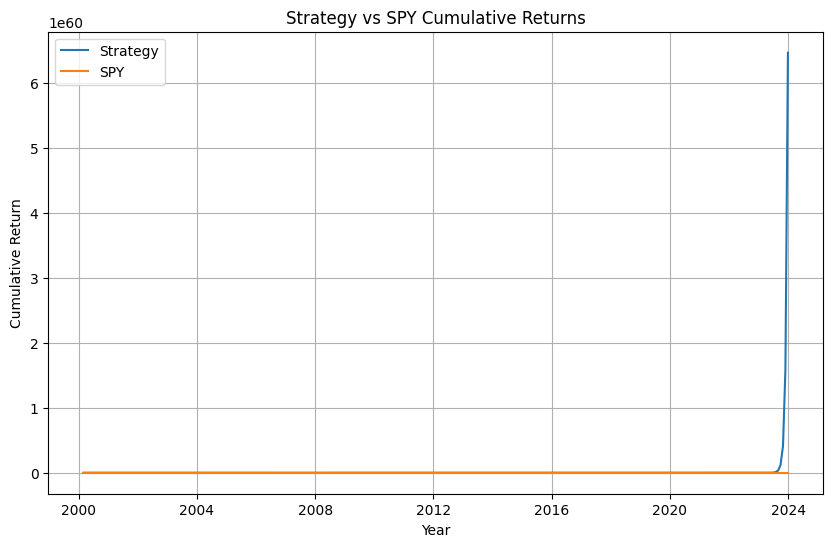

In [19]:
# Load historical SPY data
spy_data = yf.download('SPY', start='2000-01-01', end='2023-12-31')

# Resample to monthly data
spy_data['Return'] = spy_data['Adj Close'].pct_change()
spy_data['Month'] = spy_data.index.month
spy_data['Year'] = spy_data.index.year
spy_data_monthly = spy_data.resample('M').apply({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum',
    'Return': 'sum'
})



spy_data = fetch_and_display_statistics(ticker='SPY', start_date='2000-01-01', end_date='2023-12-31', output='df')

# Define the strategy
def apply_strategy(df):
    initial_capital = 5000  # Starting with $5,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []

    for i in range(1, len(df)):
        month = df.index[i].month
        if month in [4, 7, 11]:  # Buy in April, July, and November
            if position == 0:
                position = capital / df['Adj Close'].iloc[i]
                capital = 0
        elif month in [6, 8, 9]:  # Sell in June, August, and September
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hedge or hold
            if position > 0:
                capital = position * df['Adj Close'].iloc[i]
                position = 0
            position = capital / df['Adj Close'].iloc[i]
            capital = 0
        
        # Calculate monthly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        monthly_return = (total_value - initial_capital) / initial_capital
        returns.append(monthly_return)

    # Final capital
    if position > 0:
        capital = position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
monthly_returns, final_capital = apply_strategy(spy_data_monthly)

# Calculate performance metrics
cumulative_returns = (1 + np.array(monthly_returns)).cumprod()
total_return = (final_capital - 5000) / 5000
annualized_return = np.mean(monthly_returns) * 12
annualized_volatility = np.std(monthly_returns) * np.sqrt(12)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_monthly = spy_data_monthly.iloc[1:]  # Exclude the first month for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_monthly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_monthly.index, (spy_data_monthly['Adj Close'] / spy_data_monthly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


# 52 Week Strategy (Backtest)

In [20]:

# Example Kelly data for each week (replace with actual Kelly fractions)
kelly_fractions = pd.Series(0.2, index=spy_data_weekly.index)  # Placeholder values, use real data here

# Define the strategy
def apply_strategy(df, kelly_fractions):
    initial_capital = 25000  # Starting with $25,000
    capital = initial_capital
    position = 0  # No initial position
    returns = []

    for i in range(1, len(df)):
        week = df['Week'].iloc[i]
        kelly_fraction = kelly_fractions.iloc[i]
        
        if week in [7, 10, 12]:  # Buy in week 7, 10, and 12
            if position == 0:
                position_size = capital * kelly_fraction
                position = position_size / df['Adj Close'].iloc[i]
                capital -= position_size
        elif week in [24, 37]:  # Sell or hedge in weeks 24 and 37
            if position > 0:
                capital += position * df['Adj Close'].iloc[i]
                position = 0
        else:  # Hold position or implement a hedge
            if position > 0:
                capital += position * df['Adj Close'].iloc[i]
                position = 0
            position_size = capital * kelly_fraction
            position = position_size / df['Adj Close'].iloc[i]
            capital -= position_size
        
        # Calculate weekly return
        total_value = capital + position * df['Adj Close'].iloc[i]
        weekly_return = (total_value - initial_capital) / initial_capital
        returns.append(weekly_return)

    # Final capital
    if position > 0:
        capital += position * df['Adj Close'].iloc[-1]

    return returns, capital

# Backtest the strategy
weekly_returns, final_capital = apply_strategy(spy_data_weekly, kelly_fractions)

# Calculate performance metrics
cumulative_returns = (1 + np.array(weekly_returns)).cumprod()
total_return = (final_capital - 25000) / 25000
annualized_return = np.mean(weekly_returns) * 52
annualized_volatility = np.std(weekly_returns) * np.sqrt(52)
sharpe_ratio = annualized_return / annualized_volatility

# Print performance metrics
print(f"Final Portfolio Value: ${final_capital:.2f}")
print(f"Total Return: {total_return * 100:.2f}%")
print(f"Annualized Return: {annualized_return * 100:.2f}%")
print(f"Annualized Volatility: {annualized_volatility * 100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

# Ensure x and y have the same length
spy_data_weekly = spy_data_weekly.iloc[1:]  # Exclude the first week for alignment

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(spy_data_weekly.index, cumulative_returns, label='Strategy')
plt.plot(spy_data_weekly.index, (spy_data_weekly['Adj Close'] / spy_data_weekly['Adj Close'].iloc[0]), label='SPY')
plt.title('Strategy vs SPY Cumulative Returns')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'spy_data_weekly' is not defined